<a href="https://colab.research.google.com/github/Mjoe00/Behaviour-Intention-Gap/blob/Master/Gap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:
from google.colab import files
import pickle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sn
import re
import xlwt
from xlwt import Workbook
import copy

In [180]:
from scipy import stats

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

In [181]:
from google.colab import drive

drive.mount('/content/gdrive')

f=open('/content/gdrive/MyDrive/ColabNotebooks/app_data_sept.pkl','rb')
data=pickle.load(f)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [182]:
g=open('/content/gdrive/MyDrive/ColabNotebooks/app_data_Jan15.pkl','rb')
data2=pickle.load(g)

# Cendri's Challenge: Correlate everything from June to September

In [183]:
#defining a function to keep task date
def keepdate(index):
  realDate = np.array(data[index]['StartDate'])
  for i in range (len(realDate)):
    realDate[i] = realDate[i][0:10]
  return realDate

In [184]:
# make new dictionary with only my variables organized by date
chall = {"Date" : ["2021-06-01"]}

for i in range(91):
  previousDate = chall["Date"][i]
  Date = datetime.datetime.strptime(previousDate, "%Y-%m-%d") + datetime.timedelta(days=1)
  chall["Date"].append(str(Date)[:-9])

len(chall['Date'])

92

In [185]:
Participant = "ff6860f4-c110-4545-9297-95f8888d2e03"
#229876e0-c6b0-42b7-9d83-85f07f12eb05
#01801252-3a7e-4f5f-8b6d-49e8da3902f3
#aa537073-0535-401a-b9c8-7ec1c802e0d0	
#ff6860f4-c110-4545-9297-95f8888d2e03 This is Michael's participant code

In [186]:
#initializing affect variables and a dictionary
lent = ['null'] * len(chall['Date'])
challenge={'Date' : chall['Date'],
    'affect_neg_frustrated': lent.copy(),
 'affect_pos_relaxedCalm':lent.copy(),
 'affect_neg_upset':lent.copy(),
 'affect_pos_excited':lent.copy(),
 'affect_neg_stressed':lent.copy(),
 'affect_pos_motivated':lent.copy(),
 'affect_neg_angry':lent.copy(),
 'affect_pos_happy':lent.copy(),
 'affect_neg_nervousAnxious':lent.copy(),
 'affect_pos_focused':lent.copy(),
 'affect_neg_lonelyIsolated':lent.copy(),
 'affect_pos_engaged':lent.copy(),
 'affect_neg_guilty':lent.copy(),
 'affect_pos_hopeful':lent.copy(),
 'affect_neg_sad':lent.copy(),
 'affect_pos_amused':lent.copy(),
 'affect_neg_bored':lent.copy(),
 'affect_pos_loved':lent.copy(),
 'affect_neg_lazy':lent.copy(),
 'affect_pos_admired':lent.copy()
    
}
AffectIdentifier = []

#looping through one instance of the measure to get all the unique values of the affect measure
for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
  if data['SurveyQuestionResults']['SurveyResultKey'][i] == "fd92112c-c115-ec11-aab0-0afb9334277d":
    AffectIdentifier.append(data['SurveyQuestionResults']['ResultIdentifier'][i])

#unique values
AffectIdentifier

['affect_neg_frustrated',
 'affect_pos_relaxedCalm',
 'affect_neg_upset',
 'affect_pos_excited',
 'affect_neg_stressed',
 'affect_pos_motivated',
 'affect_neg_angry',
 'affect_pos_happy',
 'affect_neg_nervousAnxious',
 'affect_pos_focused',
 'affect_neg_lonelyIsolated',
 'affect_pos_engaged',
 'affect_neg_guilty',
 'affect_pos_hopeful',
 'affect_neg_sad',
 'affect_pos_amused',
 'affect_neg_bored',
 'affect_pos_loved',
 'affect_neg_lazy',
 'affect_pos_admired']

In [187]:
def fixdate(index):
  realDate = np.array(data[index]['StartDate'])
  tmp = ""
  #setting the cutoff to 4pm as if they did it in the morning or past midnight, the participant is refering to the previous day
  cutoff = datetime.datetime.strptime("160000", "%H%M%S")

  #looping to extract dates and convert them into manipuable numbers
  #note this does not account for leap years
  #this is incase someone submits past midnight or if someone does the app in the morning it will align the previous gap properly

  for i in range (len(realDate)):
    if datetime.datetime.strptime(realDate[i][11:19], "%H:%M:%S") < cutoff:
      #is the day under 10 then you need an extra 0 at the beginning
      if (int(realDate[i][8:10])-1) < 10:
        #is it the first of the month?
        if (int(realDate[i][8:10])) == 1:
          #is the month under 10 then you need an extra 0 at the beginning
          if (int(realDate[i][5:7])-1) < 10:
            #is it january first?
            if (int(realDate[i][5:7])-1) == 1:
              #if the first of the year... fix the year
              realDate[i] = realDate[i][0:2] + str((int(realDate[i][2:4])-1)) + realDate[i][4:10]
            else:
              #if its not the first of the year but still the month is under 10... add an extra 0
              tmp = "0" + str((int(realDate[i][5:7])-1))
              realDate[i] = realDate[i][0:5] + tmp + realDate[i][7:10]
              #but then we must also make the day equal to the last day of the previous month... so we must correct it to 30,28, or 31...
              if int(realDate[i][5:7])-1 == 11 or int(realDate[i][5:7])-1 == 4 or int(realDate[i][5:7])-1 == 6 or int(realDate[i][5:7])-1 == 9:
                realDate[i] = realDate[i][0:8] + "30"
              #correcting if the month is febuary
              elif int(realDate[i][5:7])-1 == 2:
                realDate[i] = realDate[i][0:8] + "28"
              else:
                #or else just make the day 31
                realDate[i] = realDate[i][0:8] + "31"

        else:
          #if the day is not the first but under 10 then correct the day...
          tmp = "0" + str((int(realDate[i][8:10])-1))
          realDate[i] = realDate[i][0:8] + tmp
        
      else:
          #if the day is not even under 10 if corrected then just subtract a day
          realDate[i] = realDate[i][0:8] + str((int(realDate[i][8:10])-1))
    else:
      #if its not even under the cutoff then set it to this...
      realDate[i] = realDate[i][0:10]
  return realDate

data["SurveyQuestionResults"]['CorrectedDate'] = fixdate("SurveyQuestionResults")

In [188]:
#organizing the answers into their respective key in the affects dictionary
for i in range(len(data['SurveyQuestionResults']['Answers'])):
  for j in range(len(AffectIdentifier)):
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == AffectIdentifier[j] and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == Participant:
      for x in range(len(challenge['Date'])):
        if str(data['SurveyQuestionResults']['CorrectedDate'][i]) == challenge['Date'][x]:
          challenge[AffectIdentifier[j]][x] = data['SurveyQuestionResults']['Answers'][i]



Reaction time:

In [189]:
data["SurveyReactionTimeResults"]['CorrectedDate'] = keepdate("SurveyReactionTimeResults")

challenge['RT'] = lent.copy()
rtident = data['SurveyReactionTimeResults']['SurveyResultKey'].unique()
avglist = {'avg' : [0] * len(data['SurveyReactionTimeResults']['SurveyResultKey'].unique()), 'date0' : [0] * len(data['SurveyReactionTimeResults']['SurveyResultKey'].unique())}
tmp =  [0] * len(data['SurveyReactionTimeResults']['SurveyResultKey'].unique())

for i in range(len(data['SurveyReactionTimeResults']['SurveyResultKey'])):
  for j in range(len(rtident)):
    if rtident[j] == data['SurveyReactionTimeResults']['SurveyResultKey'][i] and data['SurveyReactionTimeResults']['ParticipantIdentifier'][i] == Participant:
      if avglist['avg'][j] == 0:
        avglist['avg'][j] = avglist['avg'][j] + data['SurveyReactionTimeResults']['ReactionTime'][i]
        tmp[j] = 1
      else:
        avglist['avg'][j] = ((avglist['avg'][j]*tmp[j]) + data['SurveyReactionTimeResults']['ReactionTime'][i])/(tmp[j]+1)
        tmp[j] += 1
      avglist['date0'][j] = data['SurveyReactionTimeResults']['CorrectedDate'][i]

for i in range(len(challenge['RT'])):
  for x in range(len(avglist['date0'])):
    if challenge['Date'][i] == avglist["date0"][x]:
      challenge['RT'][i] = avglist['avg'][x] 




Tower of Hanoi

In [190]:
data["SurveyTowerOfHanoiResults"]['CorrectedDate'] = keepdate("SurveyTowerOfHanoiResults")

score = []

for i in range(len(data['SurveyTowerOfHanoiResults']['StartDate'])):
    placeholder = data['SurveyTowerOfHanoiResults']['Moves'][i][-71:]
    score.append(float(re.findall("\d+\.\d+", placeholder)[0]))

data['SurveyTowerOfHanoiResults']['time'] = score

nMoves = []
tmp = 0
for i in range(len(data['SurveyTowerOfHanoiResults']['Moves'])):
  for x in range(len(data['SurveyTowerOfHanoiResults']['Moves'][i])):
    if data['SurveyTowerOfHanoiResults']['Moves'][i][x] == "{":
      tmp += 1
  nMoves.append(tmp)
  tmp = 0
data['SurveyTowerOfHanoiResults']['nMoves'] = nMoves

challenge['TowerTime'] = lent.copy()
challenge['TowerMoves'] = lent.copy()

for i in range(len(data['SurveyTowerOfHanoiResults']['nMoves'])):
  for x in range(len(challenge['Date'])):
    if data['SurveyTowerOfHanoiResults']['CorrectedDate'][i] == challenge['Date'][x] and data['SurveyTowerOfHanoiResults']['ParticipantIdentifier'][i] == Participant:
      challenge['TowerTime'][x] = data['SurveyTowerOfHanoiResults']['time'][i]
      challenge['TowerMoves'][x] = data['SurveyTowerOfHanoiResults']['nMoves'][i]

Trail making B

In [191]:
data["SurveyTrailmakingResults"]['CorrectedDate'] = keepdate("SurveyTrailmakingResults")

score = []

for i in range(len(data['SurveyTrailmakingResults']['StartDate'])):
    placeholder = data['SurveyTrailmakingResults']['Taps'][i][-71:]
    score.append(float(re.findall("\d+\.\d+", placeholder)[0]))

data['SurveyTrailmakingResults']['time'] = score

challenge['TrailTime'] = lent.copy()
challenge['TrailErrors'] = lent.copy()

for i in range(len(data['SurveyTrailmakingResults']['NumberOfErrors'])):
  for x in range(len(challenge['Date'])):
    if data['SurveyTrailmakingResults']['CorrectedDate'][i] == challenge['Date'][x] and data['SurveyTrailmakingResults']['ParticipantIdentifier'][i] == Participant:
      challenge['TrailTime'][x] = data['SurveyTrailmakingResults']['time'][i]
      challenge['TrailErrors'][x] = data['SurveyTrailmakingResults']['NumberOfErrors'][i]

Spatial Memory

In [192]:
data["SurveySpatialSpanMemoryResults"]['CorrectedDate'] = keepdate("SurveySpatialSpanMemoryResults")

challenge['SpatialMemoryScore'] = lent.copy()

for i in range(len(data['SurveySpatialSpanMemoryResults']['Score'])):
  for x in range(len(challenge['Date'])):
    if data['SurveySpatialSpanMemoryResults']['CorrectedDate'][i] == challenge['Date'][x] and data['SurveySpatialSpanMemoryResults']['ParticipantIdentifier'][i] == Participant:
      challenge['SpatialMemoryScore'][x] = data['SurveySpatialSpanMemoryResults']['Score'][i]

Serial Addition

In [193]:
data["SurveyPSATResults"]['CorrectedDate'] = keepdate("SurveyPSATResults")

challenge['PSAT'] = lent.copy()

for i in range(len(data['SurveyPSATResults']['TotalCorrect'])):
  for x in range(len(challenge['Date'])):
    if data['SurveyPSATResults']['CorrectedDate'][i] == challenge['Date'][x] and data['SurveyPSATResults']['ParticipantIdentifier'][i] == Participant:
      challenge['PSAT'][x] = data['SurveyPSATResults']['TotalCorrect'][i]

Stroop Task

In [194]:
data["SurveyStroopResults"]['CorrectedDate'] = keepdate("SurveyStroopResults")


congruent = data['SurveyStroopResults']['Color'].copy()
correct = data['SurveyStroopResults']['Color'].copy()
rt = data['SurveyStroopResults']['Color'].copy()

for i in range(len(data['SurveyStroopResults']['Color'])):
  if data['SurveyStroopResults']['Color'][i] == data['SurveyStroopResults']['Text'][i]:
    congruent[i] = True
  else:
    congruent[i] = False

  if data['SurveyStroopResults']['Color'][i] == data['SurveyStroopResults']['ColorSelected'][i]:
    correct[i] = True
  else:
    correct[i] = False
  rt[i] = (data['SurveyStroopResults']['EndTime'][i] - data['SurveyStroopResults']['StartTime'][i]) *1000

data['SurveyStroopResults']['rt'] = rt
data['SurveyStroopResults']['congruent'] = congruent
data['SurveyStroopResults']['correct'] = correct

numcongru = np.zeros(len(challenge['Date']))
congruavg = np.zeros(len(challenge['Date']))
numincon = np.zeros(len(challenge['Date']))
inconavg = np.zeros(len(challenge['Date']))

for i in range(len(challenge['Date'])):
  for x in range(len(data['SurveyStroopResults']['Color'])):
    if challenge['Date'][i] == data['SurveyStroopResults']['CorrectedDate'][x] and data['SurveyStroopResults']['correct'][x] == True and data['SurveyStroopResults']['ParticipantIdentifier'][x] == Participant:
      if  data['SurveyStroopResults']['congruent'][x] == True:
        congruavg[i] =  (data['SurveyStroopResults']['rt'][x] + (congruavg[i]*numcongru[i]))/(numcongru[i]+1)
        numcongru = numcongru + 1
      else:
        inconavg[i] =  (data['SurveyStroopResults']['rt'][x] + (inconavg[i]*numincon[i]))/(numincon[i]+1)
        numincon = numincon + 1

challenge['Stroopcost'] = lent.copy()
for i in range(len(challenge['Date'])):
  challenge['Stroopcost'][i] = inconavg[i] - congruavg[i]
  if challenge['Stroopcost'][i] == 0:
    challenge['Stroopcost'][i] = 'null'

Survey: self report and gap

In [195]:
l = ['null'] * len(challenge['Date'])
challenge['DAILY_specific_past24_sleep'] = l.copy()
challenge['DAILY_specific_past24_jobSchool'] = l.copy()
challenge['DAILY_specific_past24_leisureSolo'] = l.copy()
challenge['DAILY_specific_past24_leisureNonSolo'] = l.copy()
challenge['DAILY_specific_past24_exercise'] = l.copy()
challenge['DAILY_specific_past24_drinks'] = l.copy()
challenge['DAILY_specific_past24_unpaidWork'] = l.copy()
challenge['DAILY_global_past24_gap']= l.copy()

goalkey = ['DAILY_specific_past24_sleep',
 'DAILY_specific_past24_jobSchool',
 'DAILY_specific_past24_unpaidWork',
 'DAILY_specific_past24_leisureSolo',
 'DAILY_specific_past24_leisureNonSolo',
 'DAILY_specific_past24_exercise',
 'DAILY_specific_past24_drinks', 'DAILY_global_past24_gap']

for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
  for j in range(len(goalkey)):
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == goalkey[j]:
      for x in range(len(challenge["Date"])):
        if data['SurveyQuestionResults']['ParticipantIdentifier'][i] == Participant and challenge["Date"][x] == data['SurveyQuestionResults']['CorrectedDate'][i]:
          challenge[goalkey[j]][x] = data['SurveyQuestionResults']['Answers'][i]

#for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
#  for j in goalkey:
#    for x in range(len(challenge["Date"])):
#      if data['SurveyQuestionResults']['ResultIdentifier'][i] == j and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == Participant and challenge["Date"][x] == data['SurveyQuestionResults']['CorrectedDate'][i]:
#        challenge[j][x] = data['SurveyQuestionResults']['Answers'][i]


# Preparing for previous 3 days heatmap and previous 1 day heatmap

In [196]:
#deleting the date variable
offtoside = challenge['Date']
del challenge['Date']

In [197]:
#creating copy for threedays prior heatmap
challenge3 = copy.deepcopy(challenge)

In [198]:
#creating keys for 3 days prior
w = list(challenge3.keys())
for i in w:
  challenge3[i+"_Previous3Days"] = copy.deepcopy(challenge3[i])

In [199]:
today = ['affect_neg_frustrated',
 'affect_pos_relaxedCalm',
 'affect_neg_upset',
 'affect_pos_excited',
 'affect_neg_stressed',
 'affect_pos_motivated',
 'affect_neg_angry',
 'affect_pos_happy',
 'affect_neg_nervousAnxious',
 'affect_pos_focused',
 'affect_neg_lonelyIsolated',
 'affect_pos_engaged',
 'affect_neg_guilty',
 'affect_pos_hopeful',
 'affect_neg_sad',
 'affect_pos_amused',
 'affect_neg_bored',
 'affect_pos_loved',
 'affect_neg_lazy',
 'affect_pos_admired',
 'RT',
 'TowerTime',
 'TowerMoves',
 'TrailTime',
 'TrailErrors',
 'SpatialMemoryScore',
 'PSAT',
 'Stroopcost',
 'DAILY_specific_past24_sleep',
 'DAILY_specific_past24_jobSchool',
 'DAILY_specific_past24_leisureSolo',
 'DAILY_specific_past24_leisureNonSolo',
 'DAILY_specific_past24_exercise',
 'DAILY_specific_past24_drinks',
 'DAILY_specific_past24_unpaidWork',
 'DAILY_global_past24_gap']

yesterday = ['affect_neg_frustratedYesterday',
 'affect_pos_relaxedCalmYesterday',
 'affect_neg_upsetYesterday',
 'affect_pos_excitedYesterday',
 'affect_neg_stressedYesterday',
 'affect_pos_motivatedYesterday',
 'affect_neg_angryYesterday',
 'affect_pos_happyYesterday',
 'affect_neg_nervousAnxiousYesterday',
 'affect_pos_focusedYesterday',
 'affect_neg_lonelyIsolatedYesterday',
 'affect_pos_engagedYesterday',
 'affect_neg_guiltyYesterday',
 'affect_pos_hopefulYesterday',
 'affect_neg_sadYesterday',
 'affect_pos_amusedYesterday',
 'affect_neg_boredYesterday',
 'affect_pos_lovedYesterday',
 'affect_neg_lazyYesterday',
 'affect_pos_admiredYesterday',
 'RTYesterday',
 'TowerTimeYesterday',
 'TowerMovesYesterday',
 'TrailTimeYesterday',
 'TrailErrorsYesterday',
 'SpatialMemoryScoreYesterday',
 'PSATYesterday',
 'StroopcostYesterday',
 'DAILY_specific_past24_sleepYesterday',
 'DAILY_specific_past24_jobSchoolYesterday',
 'DAILY_specific_past24_leisureSoloYesterday',
 'DAILY_specific_past24_leisureNonSoloYesterday',
 'DAILY_specific_past24_exerciseYesterday',
 'DAILY_specific_past24_drinksYesterday',
 'DAILY_specific_past24_unpaidWorkYesterday',
 'DAILY_global_past24_gapYesterday']

last3 = ['affect_neg_frustrated_Previous3Days', 
'affect_pos_relaxedCalm_Previous3Days',
'affect_neg_upset_Previous3Days', 
'affect_pos_excited_Previous3Days', 
'affect_neg_stressed_Previous3Days', 
'affect_pos_motivated_Previous3Days', 
'affect_neg_angry_Previous3Days', 
'affect_pos_happy_Previous3Days', 
'affect_neg_nervousAnxious_Previous3Days',
'affect_pos_focused_Previous3Days', 
'affect_neg_lonelyIsolated_Previous3Days', 
'affect_pos_engaged_Previous3Days', 
'affect_neg_guilty_Previous3Days', 
'affect_pos_hopeful_Previous3Days', 
'affect_neg_sad_Previous3Days', 
'affect_pos_amused_Previous3Days', 
'affect_neg_bored_Previous3Days', 
'affect_pos_loved_Previous3Days', 
'affect_neg_lazy_Previous3Days',
'affect_pos_admired_Previous3Days', 
'RT_Previous3Days', 
'TowerTime_Previous3Days', 
'TowerMoves_Previous3Days',
'TrailTime_Previous3Days',
'TrailErrors_Previous3Days',
'SpatialMemoryScore_Previous3Days',
'PSAT_Previous3Days', 
'Stroopcost_Previous3Days',
'DAILY_specific_past24_sleep_Previous3Days',
'DAILY_specific_past24_jobSchool_Previous3Days', 
'DAILY_specific_past24_leisureSolo_Previous3Days', 
'DAILY_specific_past24_leisureNonSolo_Previous3Days', 
'DAILY_specific_past24_exercise_Previous3Days', 
'DAILY_specific_past24_drinks_Previous3Days', 
'DAILY_specific_past24_unpaidWork_Previous3Days', 
'DAILY_global_past24_gap_Previous3Days']

In [200]:
#creating a function to make a previous 3 day average
def means(listy2):
  listy = list(listy2)
  sub = 0
  if listy[0] == 'null':
    del listy[0]
    sub +=1
  else:
    listy[0] = float(listy[0])
  if listy[1-sub] == 'null':
    del listy[1-sub]
    sub +=1
  else:
    listy[1-sub] = float(listy[1-sub])
  if listy[2-sub] == 'null':
    del listy[2-sub]
  else:
    listy[2-sub] = float(listy[2-sub])

  return np.mean(listy)

In [201]:
#changing values to make it 3 days prior
number = [0,0,0]
tmp = 0
for i in range(len(last3)):
  number = [challenge3[today[i]][0],challenge3[today[i]][1],challenge3[today[i]][2]]
  for x in range(len(challenge3['DAILY_specific_past24_drinks'])-3):
    tmp = challenge3[today[i]][x+3]
    challenge3[last3[i]][x+3] = means(number)
    number[0] = number[1]
    number[1] = number[2]
    number[2] = tmp
#deleting extra values so they are the same length


In [202]:
#deleting the first three days (no data before them)
for i in list(challenge3.keys()):
  del challenge3[i][0]
  del challenge3[i][0]
  del challenge3[i][0]

# Cendri's Challenge: Creating last 3 days heatmap

In [203]:
#changing null string to numpy null equivalent
w = list(challenge3.keys())

for j in w:
  for i in range(len(challenge3['affect_neg_angry'])):
    if challenge3[j][i] == "null":
      challenge3[j][i] = np.nan
    else:
      challenge3[j][i] = float(challenge3[j][i])

In [204]:
df = pd.DataFrame(challenge3,columns = list(challenge3.keys()))


                                                    affect_neg_frustrated  \
affect_neg_frustrated                                            1.000000   
affect_pos_relaxedCalm                                          -0.496586   
affect_neg_upset                                                 0.478769   
affect_pos_excited                                              -0.047145   
affect_neg_stressed                                              0.606233   
...                                                                   ...   
DAILY_specific_past24_leisureNonSolo_Previous3Days              -0.190235   
DAILY_specific_past24_exercise_Previous3Days                     0.108605   
DAILY_specific_past24_drinks_Previous3Days                       0.087677   
DAILY_specific_past24_unpaidWork_Previous3Days                   0.030563   
DAILY_global_past24_gap_Previous3Days                            0.060798   

                                                    affect_pos_relaxedCalm 

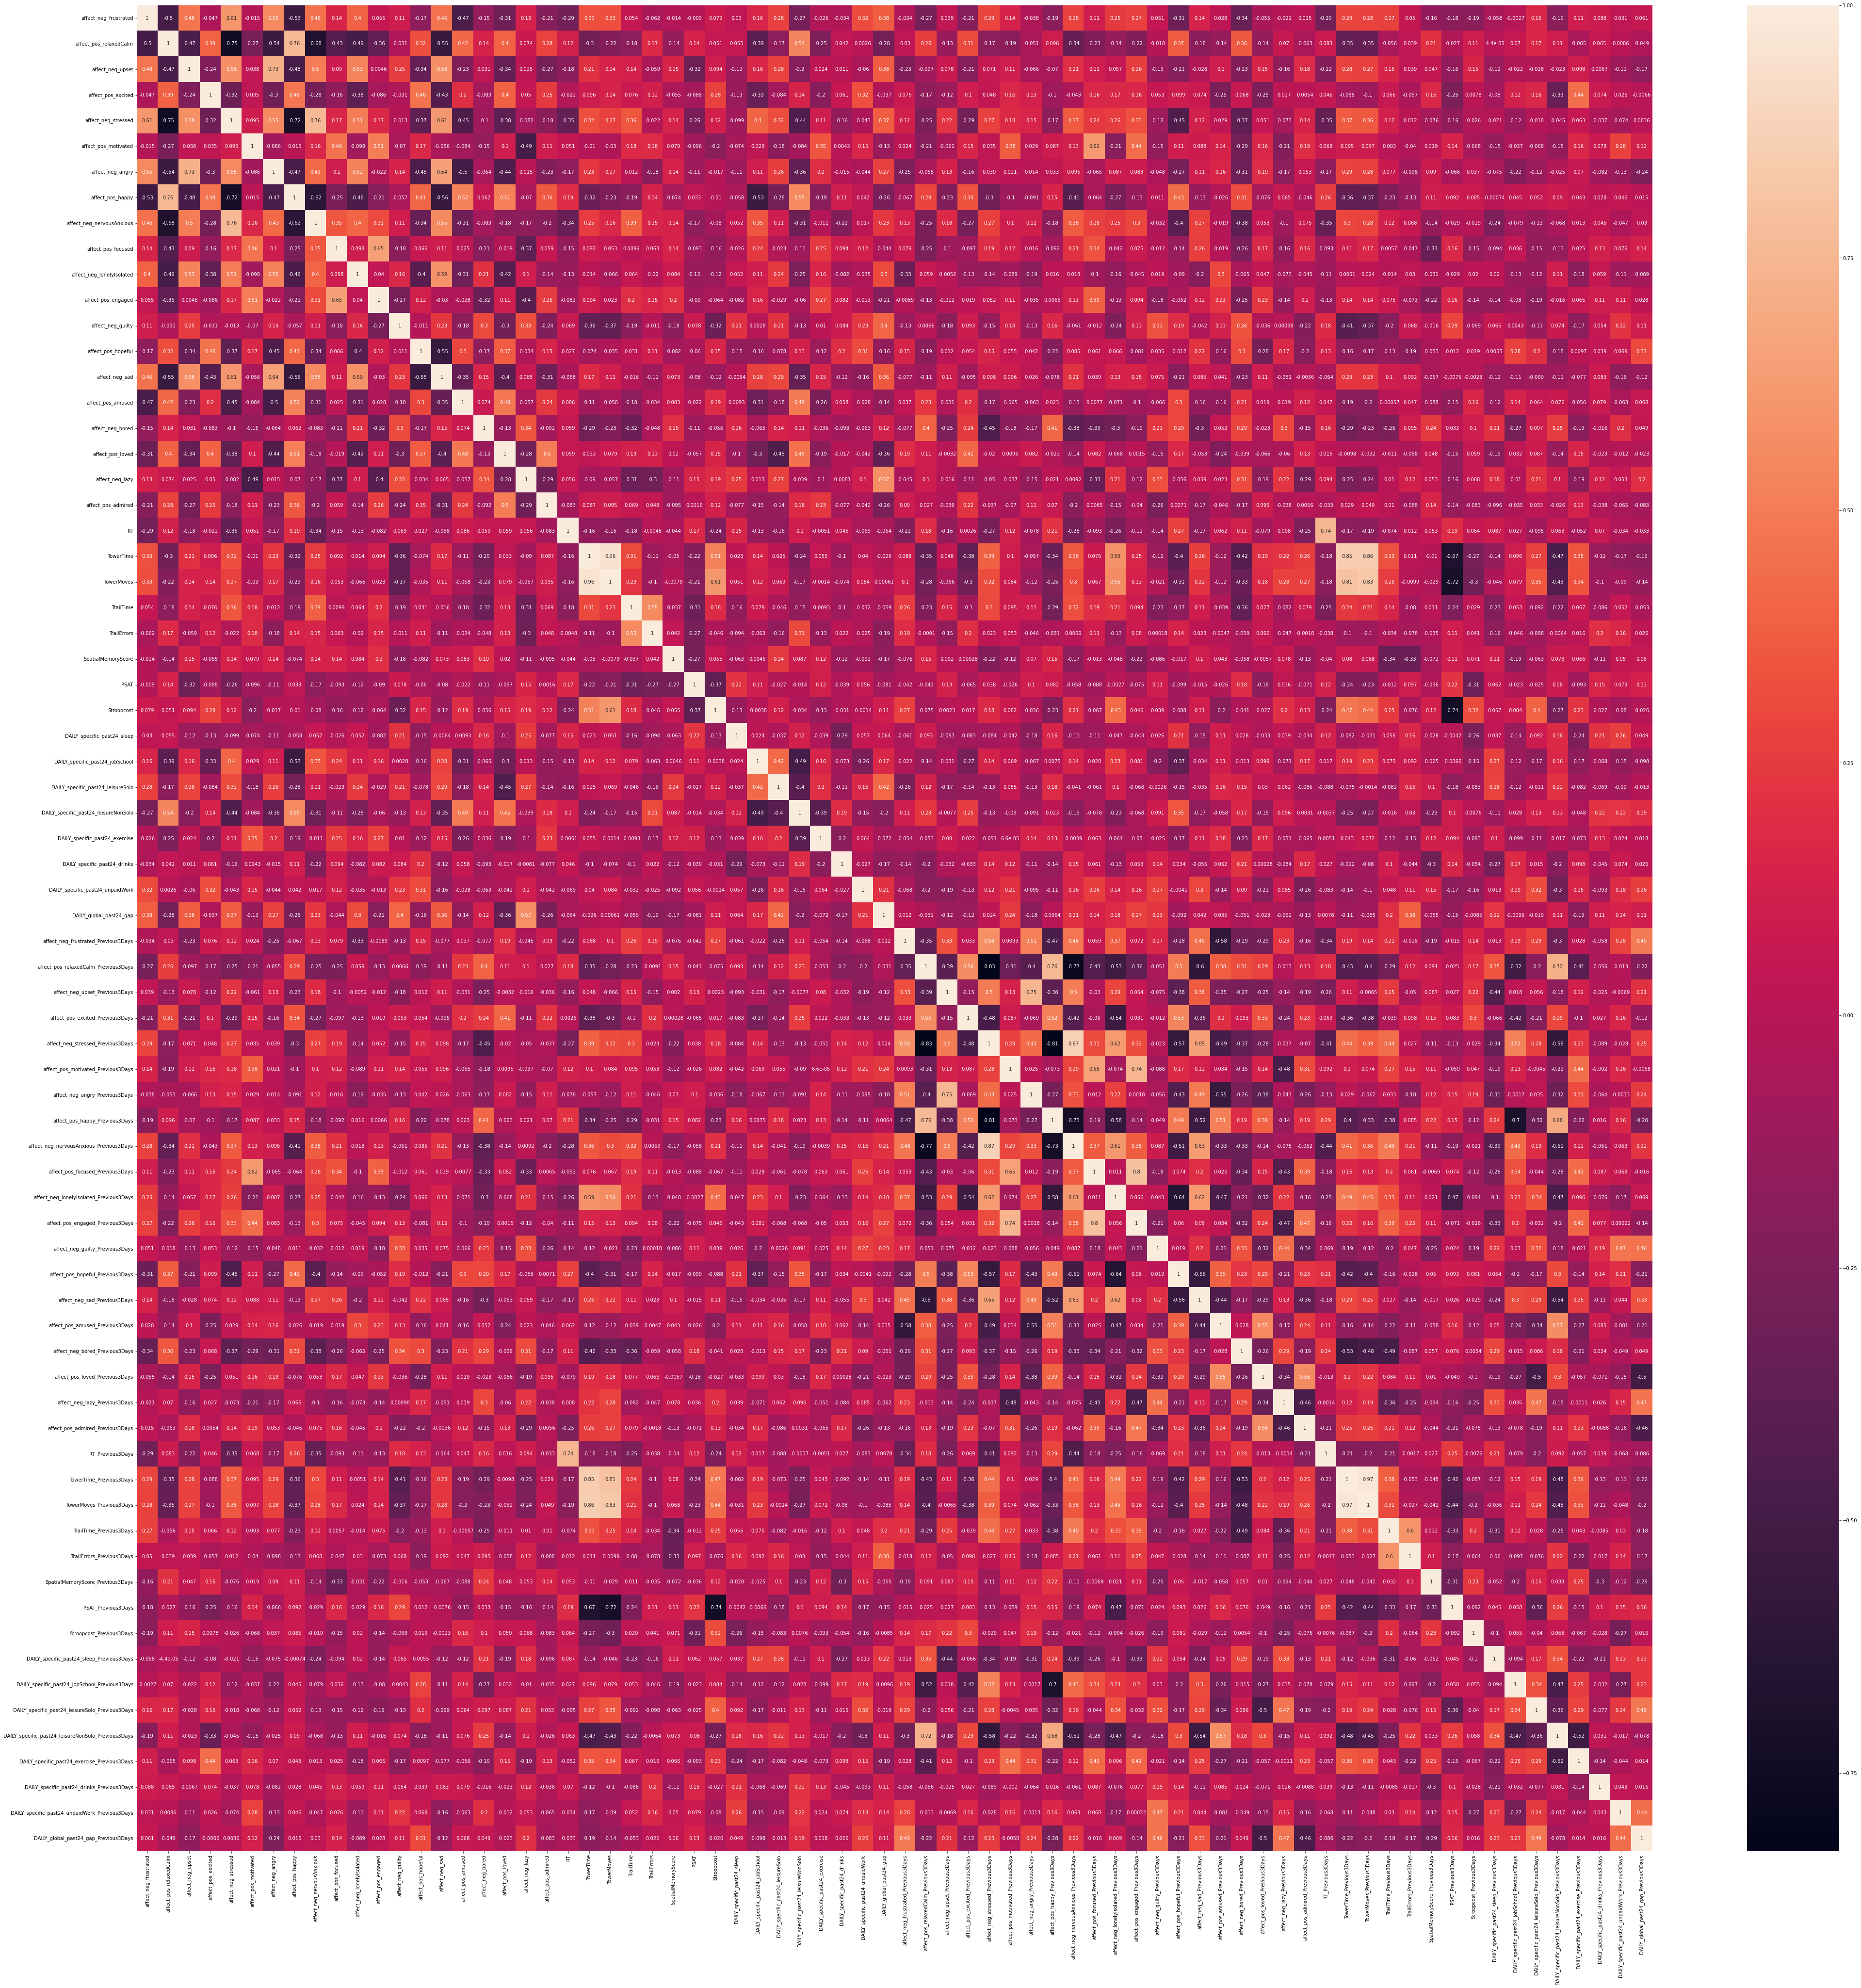

In [205]:
#creating the heapmap

df = df.dropna(how='any',axis=0) 
corrMatrix = df.corr()
print(corrMatrix)
fig, ax = plt.subplots(figsize=(70,70))  
ax = sn.heatmap(corrMatrix, xticklabels=True, yticklabels=True,annot=True)

# Cendri's Challenge: Creating last 1 day heatmap

In [206]:
#creating copy for future use
challenge1 = copy.deepcopy(challenge)

#creating keys for 1 day prior
w = list(challenge1.keys())
for i in w:
  challenge1[i+"Yesterday"] = copy.deepcopy(challenge1[i])

In [207]:
#for the 1 previous day dataset i am making the datasets line up
for i in today:
  del challenge1[i][0]

for i in yesterday:
  del challenge1[i][91]

In [208]:
#changing null string to numpy null equivalent
w = list(challenge1.keys())

for j in w:
  for i in range(len(challenge1['affect_neg_angry'])):
    if challenge1[j][i] == "null":
      challenge1[j][i] = np.nan
    else:
      challenge1[j][i] = float(challenge1[j][i])

                                               affect_neg_frustrated  \
affect_neg_frustrated                                       1.000000   
affect_pos_relaxedCalm                                     -0.568036   
affect_neg_upset                                            0.527737   
affect_pos_excited                                         -0.041056   
affect_neg_stressed                                         0.608405   
...                                                              ...   
DAILY_specific_past24_leisureNonSoloYesterday              -0.266464   
DAILY_specific_past24_exerciseYesterday                     0.070598   
DAILY_specific_past24_drinksYesterday                       0.109492   
DAILY_specific_past24_unpaidWorkYesterday                   0.326571   
DAILY_global_past24_gapYesterday                            0.143146   

                                               affect_pos_relaxedCalm  \
affect_neg_frustrated                                       -0

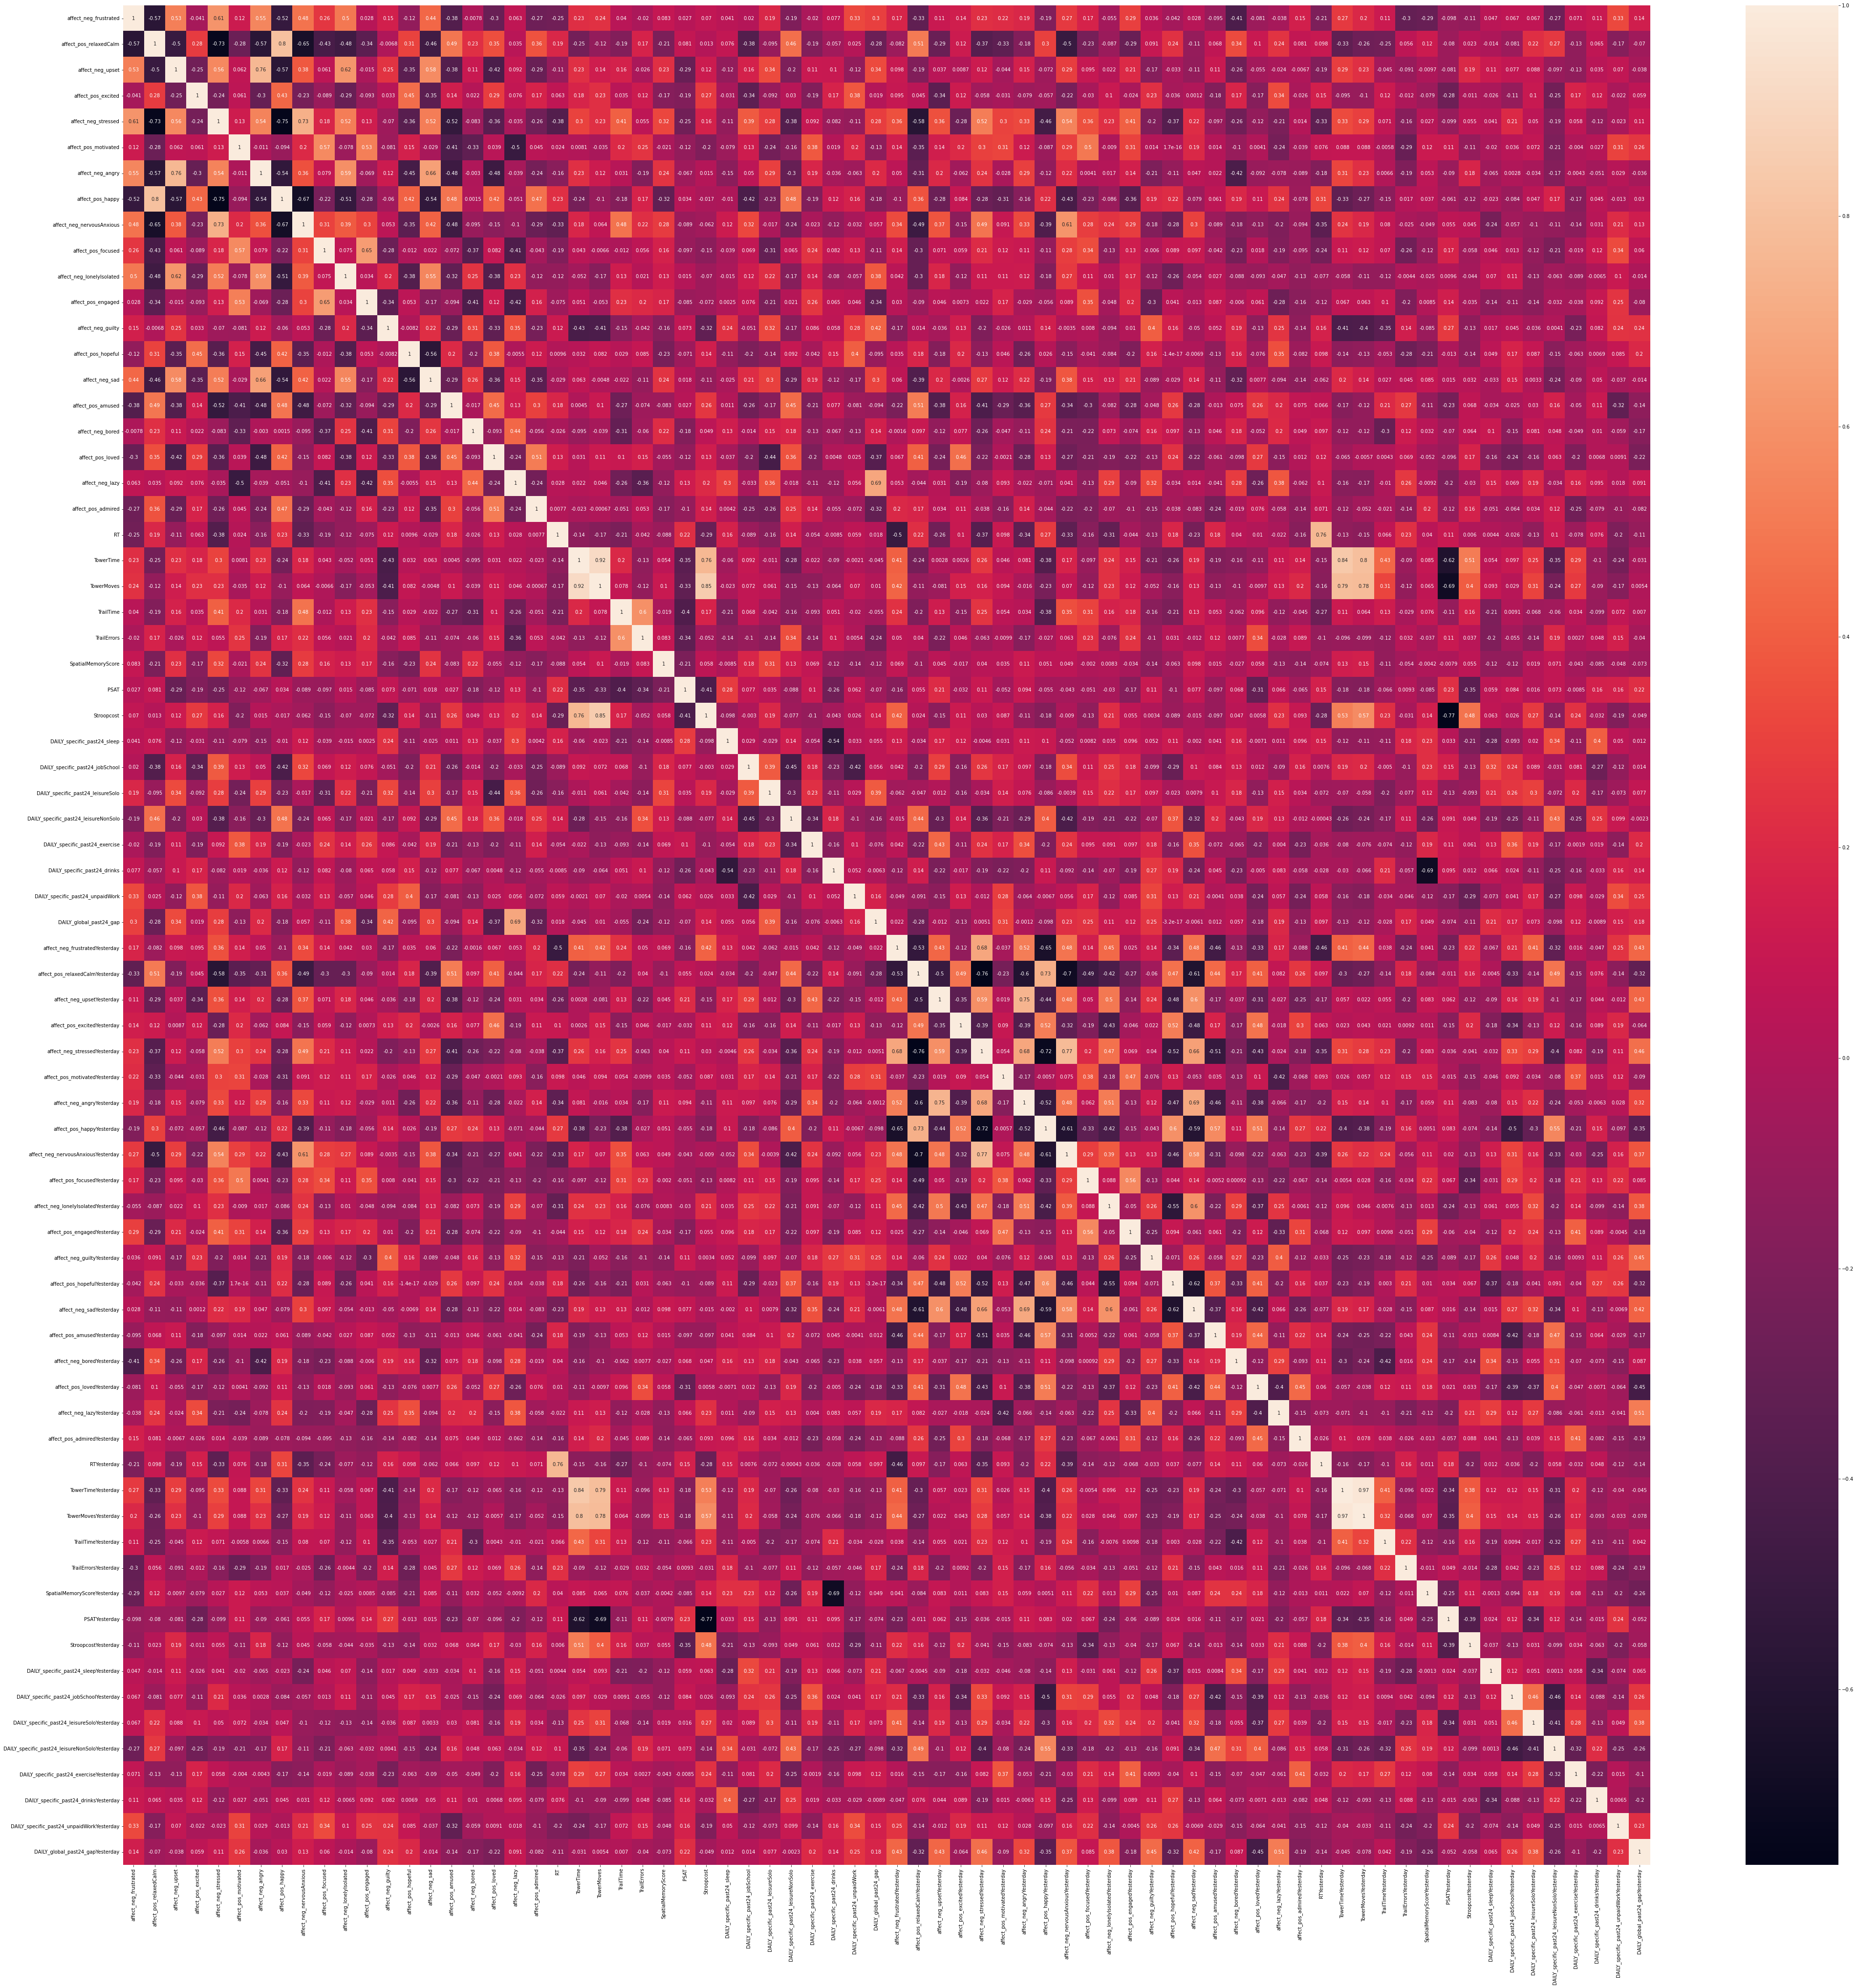

In [209]:
#creating pandas dictionary and dropping null values
df = pd.DataFrame(challenge1,columns = list(challenge1.keys()))
df = df.dropna(how='any',axis=0) 
#generating heatmap
corrMatrix = df.corr()
print(corrMatrix)
fig, ax = plt.subplots(figsize=(70,70))  
ax = sn.heatmap(corrMatrix, xticklabels=True, yticklabels=True,annot=True)

# Practice effects: graphing the data

In [210]:
#changing null string to numpy null equivalent
challenge4 = copy.deepcopy(challenge)
w = list(challenge4.keys())

for j in w:
  for i in range(len(challenge4['affect_neg_angry'])):
    if challenge4[j][i] == "null":
      challenge4[j][i] = np.nan
    else:
      challenge4[j][i] = float(challenge4[j][i])

In [211]:
#changing null string to numpy null equivalent
w = list(challenge.keys())

for j in w:
  for i in range(len(challenge['affect_neg_angry'])):
    if challenge[j][i] == "null":
      challenge[j][i] = np.nan
    else:
      challenge[j][i] = float(challenge[j][i])

In [212]:
challenge4['Date'] = offtoside
df = pd.DataFrame(challenge4,columns = list(challenge4.keys()))
df['PSAT'] = challenge['PSAT']
df['RT'] = challenge['RT']
df['TowerTime'] = challenge['TowerTime']
df['TowerMoves'] = challenge['TowerMoves']
df['Stroopcost'] = challenge['Stroopcost']
df['SpatialMemoryScore'] = challenge['SpatialMemoryScore']
df['TrailTime'] = challenge['TrailTime']
df['TrailErrors'] = challenge['TrailErrors']
df = df.dropna(how='any',axis=0) 

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61],
 <a list of 62 Text major ticklabel objects>)

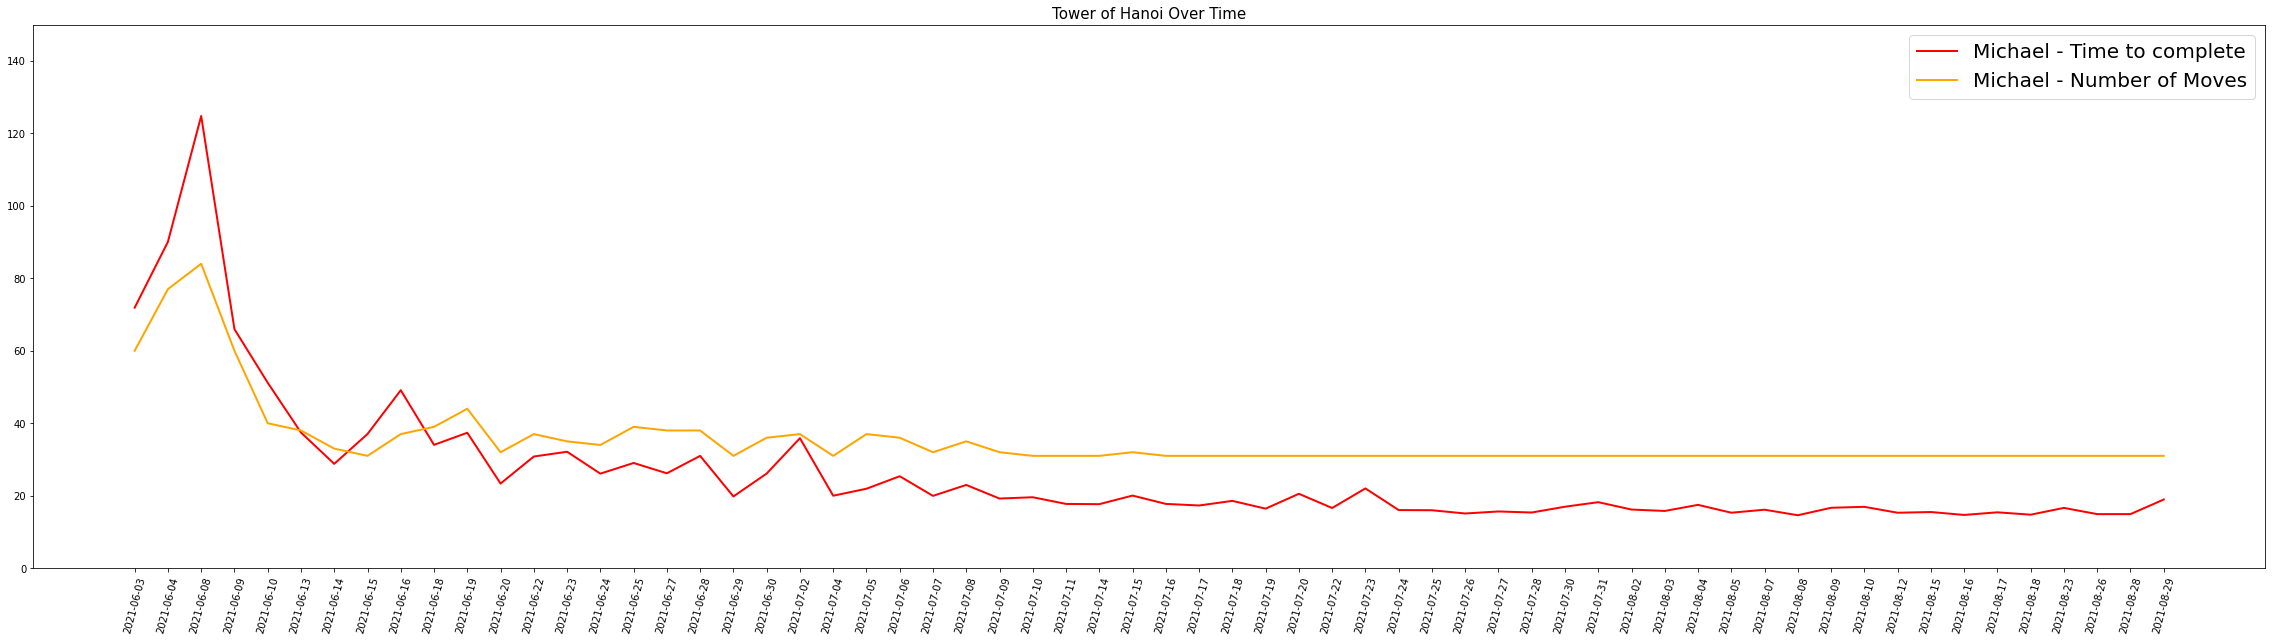

In [213]:
fig,ax = plt.subplots(1 ,figsize=(40,10))
x = df['Date']
ax.plot(x, df['TowerTime'],color="red",linewidth=2,label='Michael - Time to complete')
ax.plot(x, df['TowerMoves'],color="orange",linewidth=2,label='Michael - Number of Moves')
ax.set_title('Tower of Hanoi Over Time',fontsize=15)
ax.set_ylim(0,150)
ax.legend(fontsize=20)
plt.xticks(rotation=75)

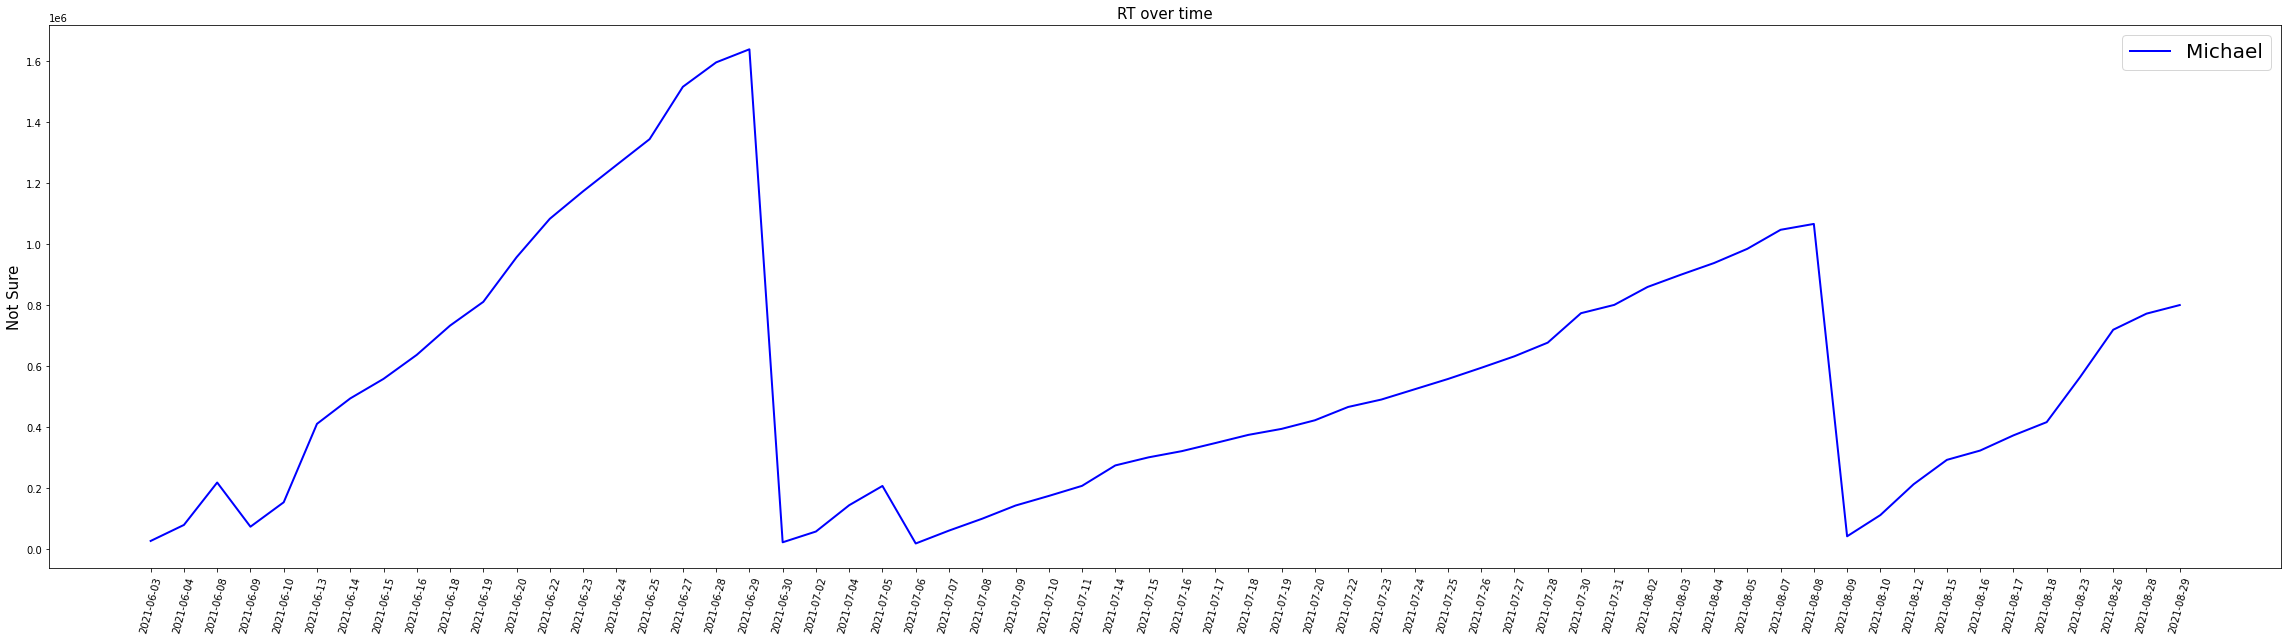

In [214]:
fig,ax = plt.subplots(1 ,figsize=(40,10))
x = df['Date']
ax.plot(x, df['RT'],color="blue",linewidth=2,label='Michael')
ax.set_ylabel('Not Sure',fontsize=15)
ax.set_title('RT over time',fontsize=15)
plt.xticks(rotation=75)
ax.legend(fontsize=20)

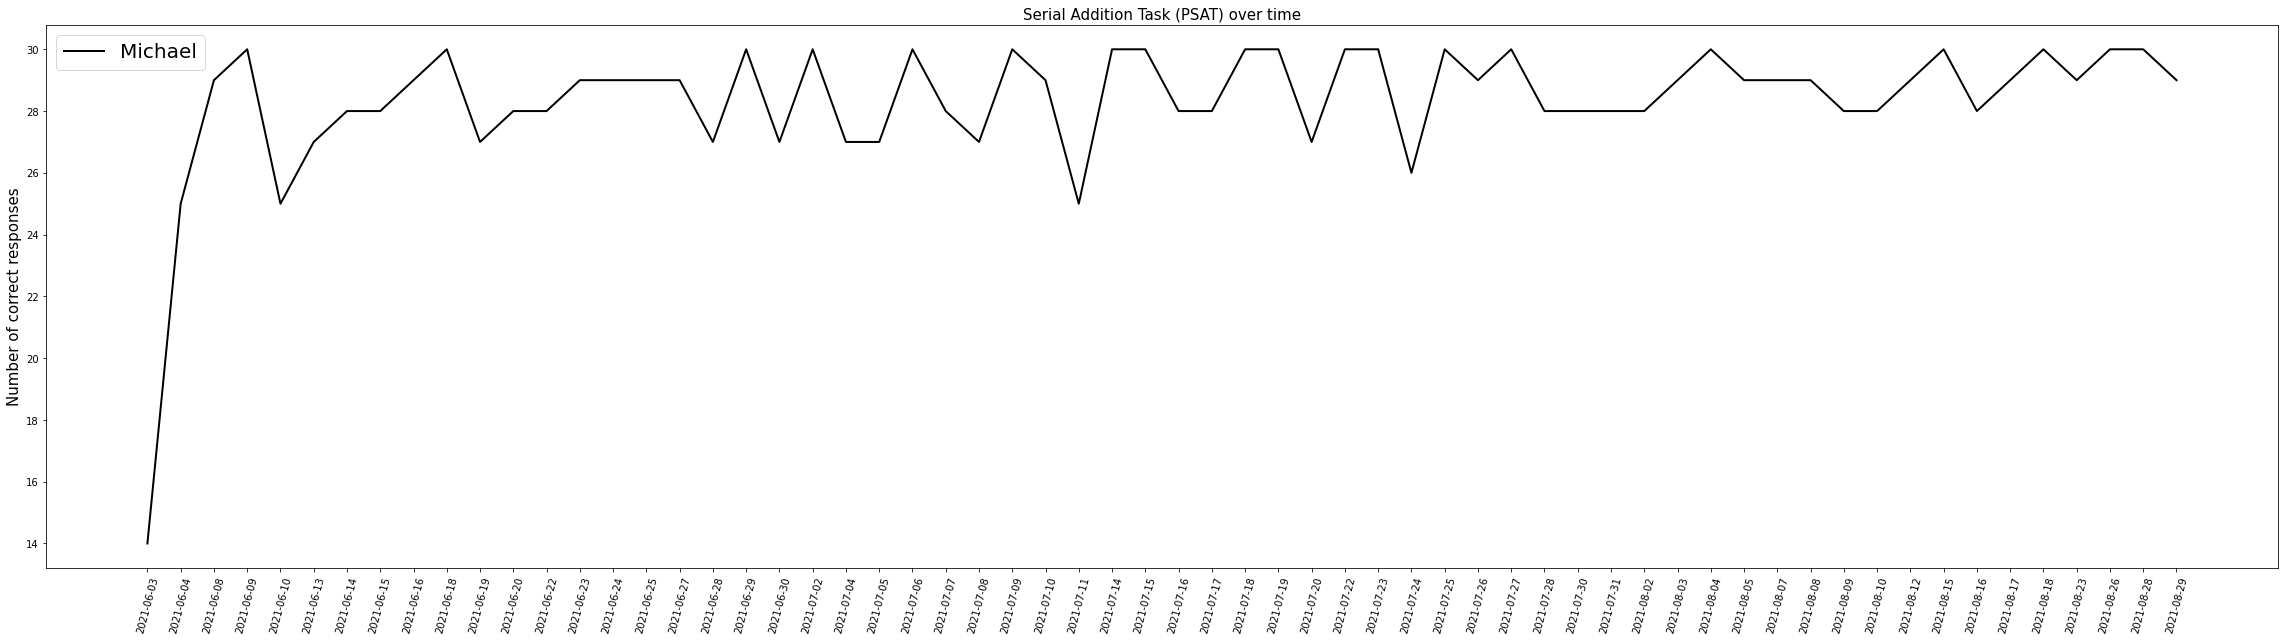

In [215]:
fig,ax = plt.subplots(1 ,figsize=(40,10))
x = df['Date']
ax.plot(x, df['PSAT'],color="black",linewidth=2,label='Michael')
ax.set_ylabel('Number of correct responses',fontsize=15)
ax.set_title('Serial Addition Task (PSAT) over time',fontsize=15)
plt.xticks(rotation=75)
ax.legend(fontsize=20)

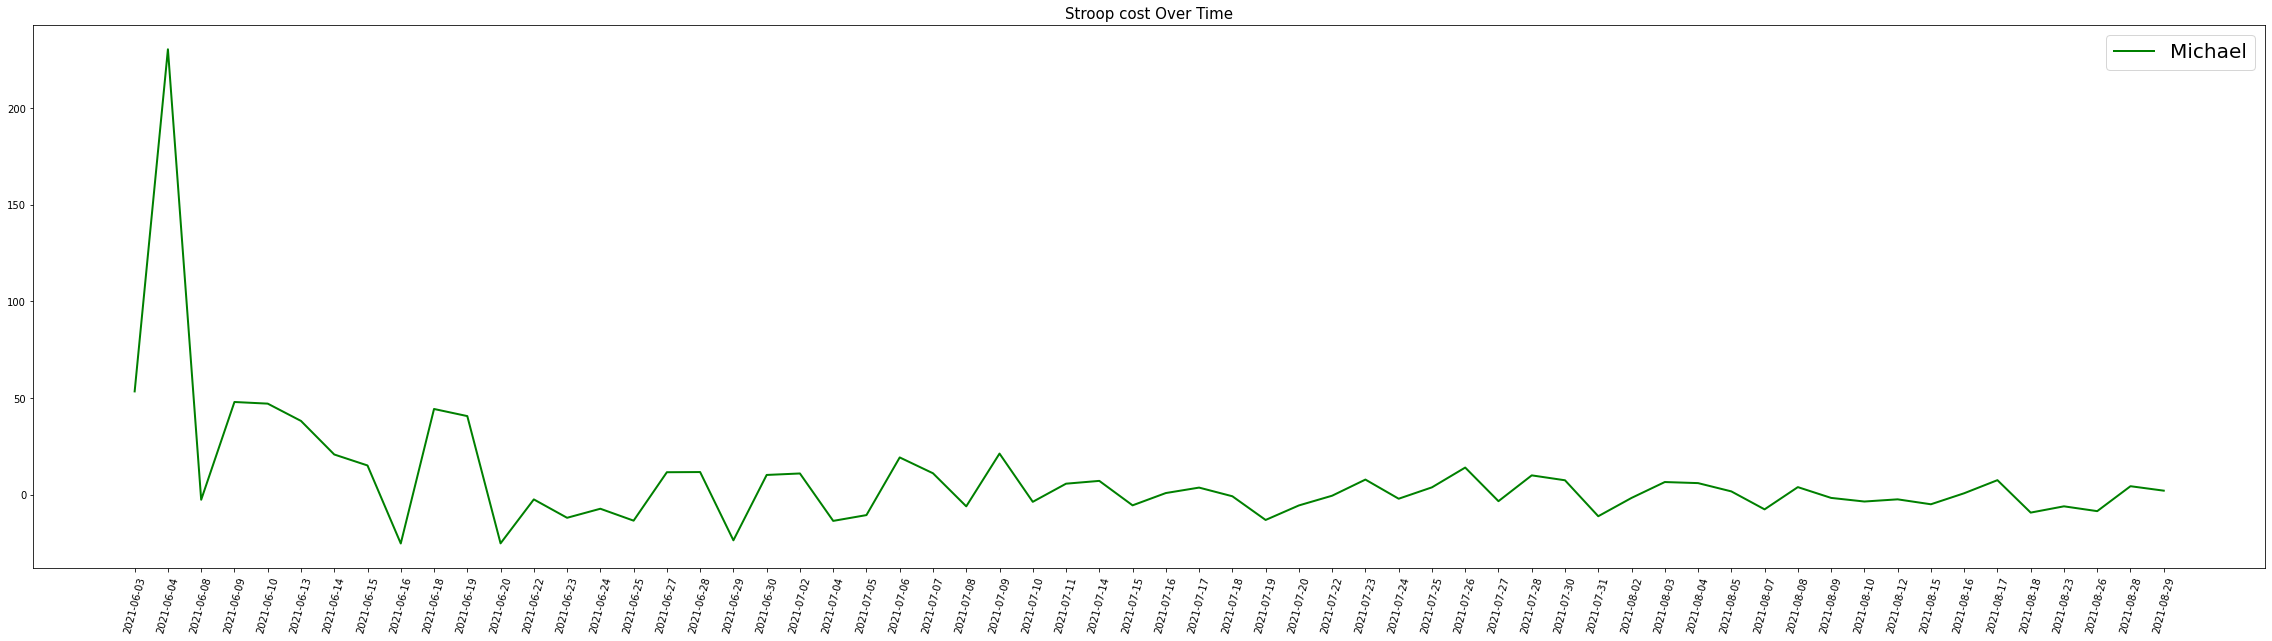

In [216]:
fig,ax = plt.subplots(1 ,figsize=(40,10))
x = df['Date']
ax.plot(x, df['Stroopcost'],color="green",linewidth=2,label="Michael")
ax.set_title('Stroop cost Over Time',fontsize=15)
plt.xticks(rotation=75)
ax.legend(fontsize=20)

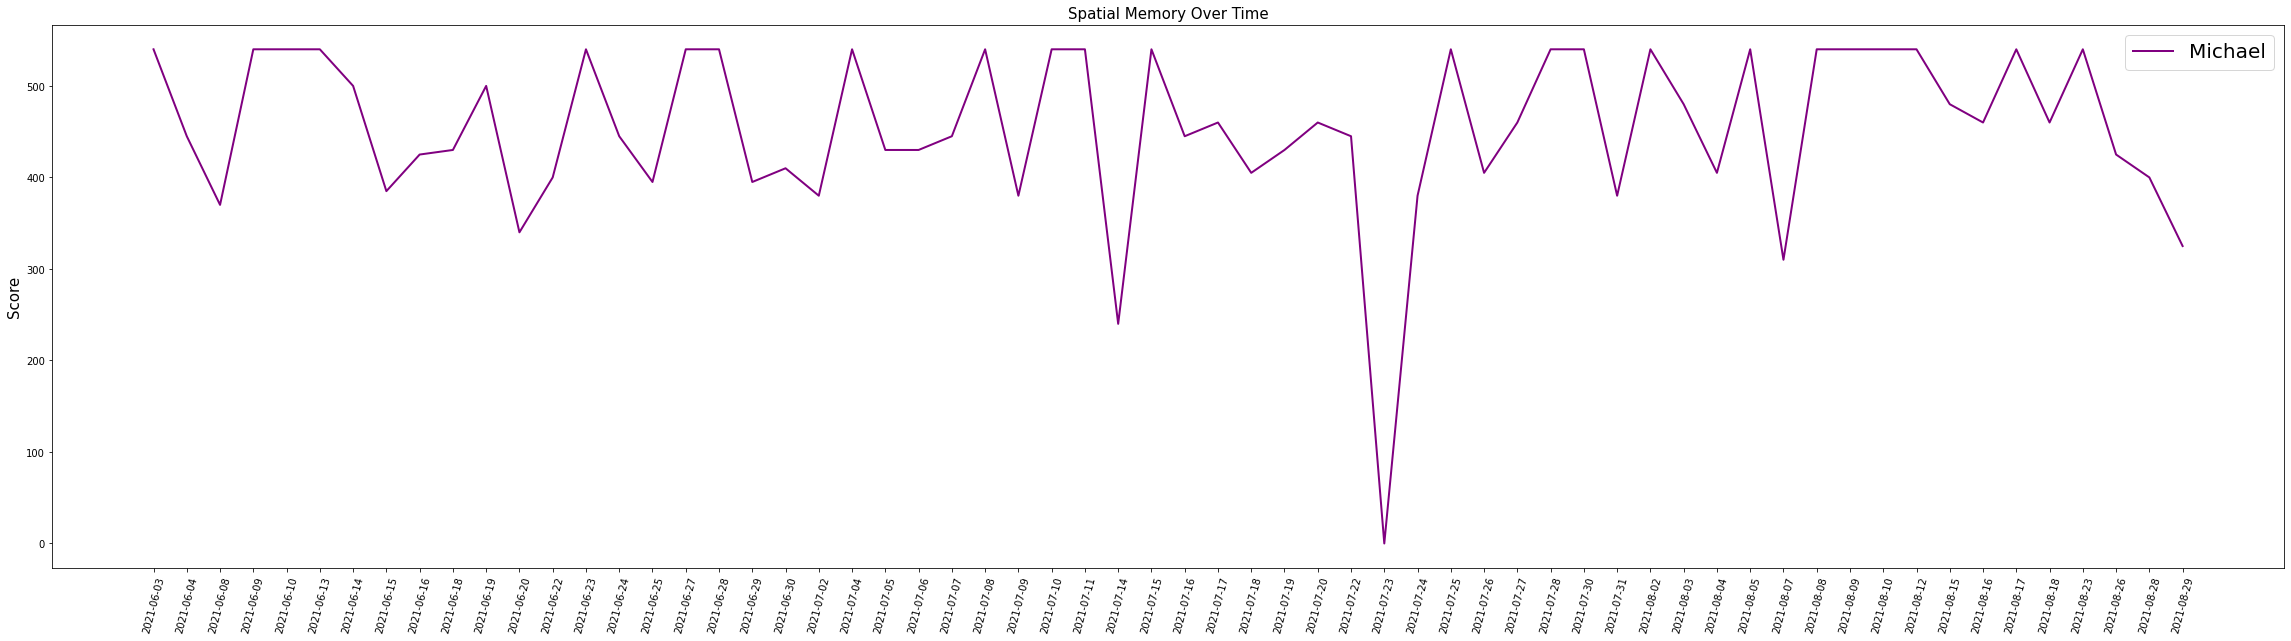

In [217]:
fig,ax = plt.subplots(1 ,figsize=(40,10))
x = df['Date']
ax.plot(x, df['SpatialMemoryScore'],color="purple",linewidth=2,label='Michael')
ax.set_title('Spatial Memory Over Time',fontsize=15)
ax.set_ylabel("Score",fontsize=15)
plt.xticks(rotation=75)
ax.legend(fontsize=20)

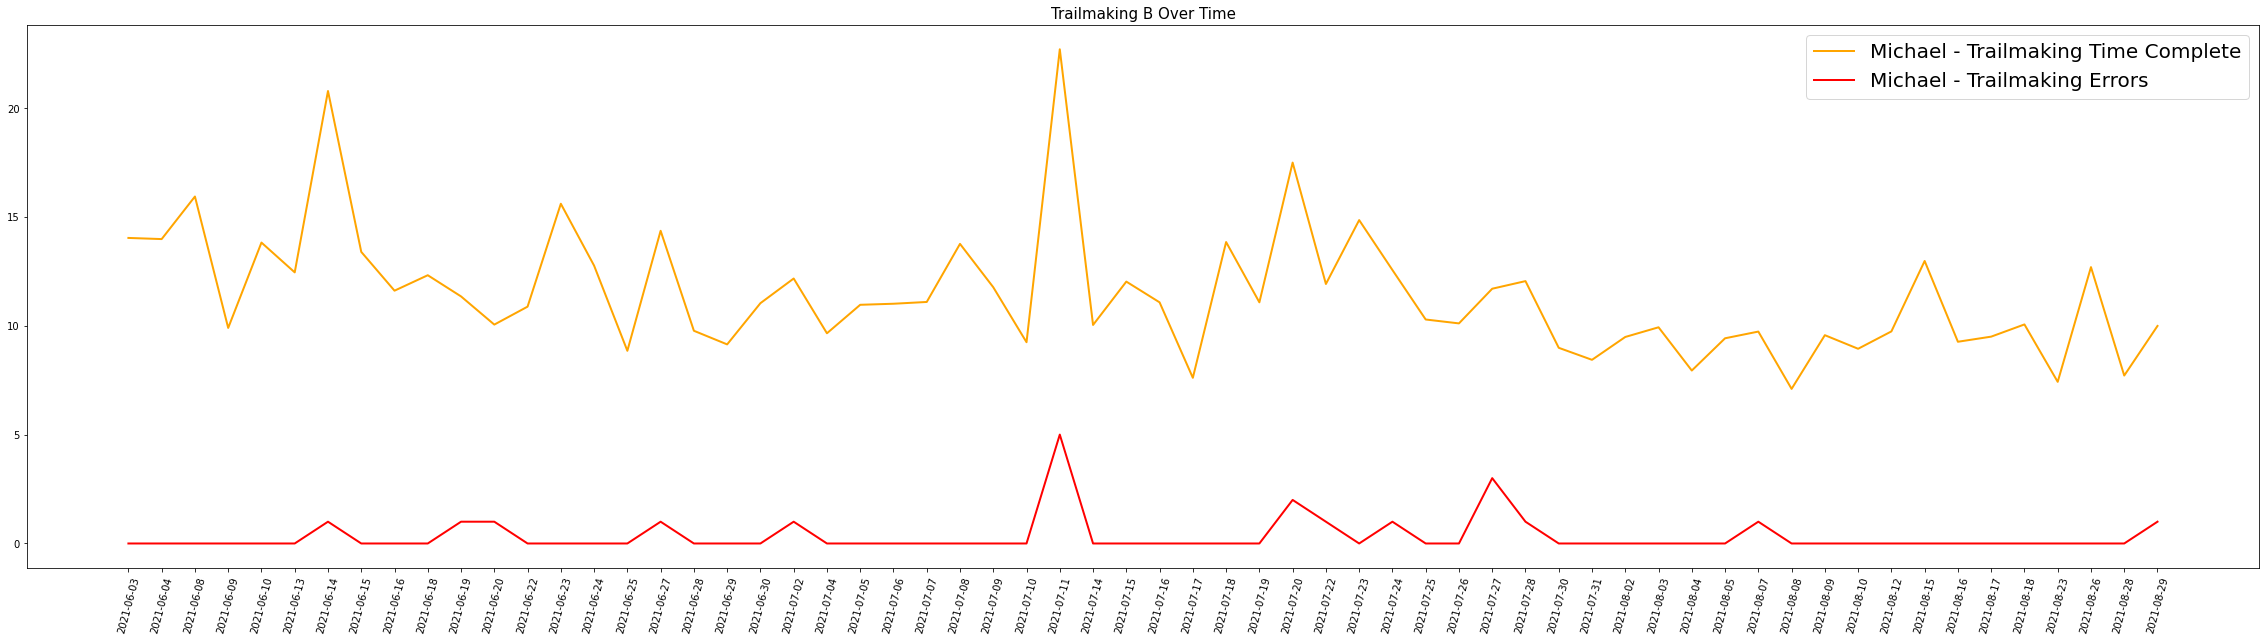

In [218]:
fig,ax = plt.subplots(1 ,figsize=(40,10))
x = df['Date']
ax.plot(x, df['TrailTime'],color="orange",linewidth=2,label='Michael - Trailmaking Time Complete')
ax.plot(x, df['TrailErrors'],color="red",linewidth=2,label='Michael - Trailmaking Errors')
ax.set_title('Trailmaking B Over Time',fontsize=15)
plt.xticks(rotation=75)
ax.legend(fontsize=20)

# Looking at the data from September onwards

In [222]:
chall = {"Date" : ["2021-09-01"]}

for i in range(91):
  previousDate = chall["Date"][i]
  Date = datetime.datetime.strptime(previousDate, "%Y-%m-%d") + datetime.timedelta(days=1)
  chall["Date"].append(str(Date)[:-9])

len(chall['Date'])

Participant = "ff6860f4-c110-4545-9297-95f8888d2e03"
#229876e0-c6b0-42b7-9d83-85f07f12eb05
#01801252-3a7e-4f5f-8b6d-49e8da3902f3
#aa537073-0535-401a-b9c8-7ec1c802e0d0	
#ff6860f4-c110-4545-9297-95f8888d2e03

def fixdate(index):
  realDate = np.array(data2[index]['StartDate'])
  tmp = ""
  #setting the cutoff to 4pm as if they did it in the morning or past midnight, the participant is refering to the previous day
  cutoff = datetime.datetime.strptime("160000", "%H%M%S")

  #looping to extract dates and convert them into manipuable numbers
  #note this does not account for leap years
  #this is incase someone submits past midnight or if someone does the app in the morning it will align the previous gap properly

  for i in range (len(realDate)):
    if datetime.datetime.strptime(realDate[i][11:19], "%H:%M:%S") < cutoff:
      #is the day under 10 then you need an extra 0 at the beginning
      if (int(realDate[i][8:10])-1) < 10:
        #is it the first of the month?
        if (int(realDate[i][8:10])) == 1:
          #is the month under 10 then you need an extra 0 at the beginning
          if (int(realDate[i][5:7])-1) < 10:
            #is it january first?
            if (int(realDate[i][5:7])-1) == 1:
              #if the first of the year... fix the year
              realDate[i] = realDate[i][0:2] + str((int(realDate[i][2:4])-1)) + realDate[i][4:10]
            else:
              #if its not the first of the year but still the month is under 10... add an extra 0
              tmp = "0" + str((int(realDate[i][5:7])-1))
              realDate[i] = realDate[i][0:5] + tmp + realDate[i][7:10]
              #but then we must also make the day equal to the last day of the previous month... so we must correct it to 30,28, or 31...
              if int(realDate[i][5:7])-1 == 11 or int(realDate[i][5:7])-1 == 4 or int(realDate[i][5:7])-1 == 6 or int(realDate[i][5:7])-1 == 9:
                realDate[i] = realDate[i][0:8] + "30"
              #correcting if the month is febuary
              elif int(realDate[i][5:7])-1 == 2:
                realDate[i] = realDate[i][0:8] + "28"
              else:
                #or else just make the day 31
                realDate[i] = realDate[i][0:8] + "31"

        else:
          #if the day is not the first but under 10 then correct the day...
          tmp = "0" + str((int(realDate[i][8:10])-1))
          realDate[i] = realDate[i][0:8] + tmp
        
      else:
          #if the day is not even under 10 if corrected then just subtract a day
          realDate[i] = realDate[i][0:8] + str((int(realDate[i][8:10])-1))
    else:
      #if its not even under the cutoff then set it to this...
      realDate[i] = realDate[i][0:10]
  return realDate

data2["SurveyQuestionResults"]['CorrectedDate'] = fixdate("SurveyQuestionResults")

#defining a function to keep task date
def keepdate(index):
  realDate = np.array(data2[index]['StartDate'])
  for i in range (len(realDate)):
    realDate[i] = realDate[i][0:10]
  return realDate

In [223]:
#initializing some variables and a dictionary
lent = ['null'] * len(chall['Date'])
challenge={'Date' : chall['Date'],
    'affect_neg_frustrated': lent.copy(),
 'affect_pos_relaxedCalm':lent.copy(),
 'affect_neg_ashamed':lent.copy(),
 'affect_pos_excited':lent.copy(),
 'affect_neg_stressed':lent.copy(),
 'affect_pos_motivated':lent.copy(),
 'affect_neg_angry':lent.copy(),
 'affect_pos_happy':lent.copy(),
 'affect_neg_nervousAnxious':lent.copy(),
 'affect_pos_focused':lent.copy(),
 'affect_neg_lonelyIsolated':lent.copy(),
 'affect_pos_appreciated':lent.copy(),
 'affect_neg_guilty':lent.copy(),
 'affect_pos_hopeful':lent.copy(),
 'affect_neg_sad':lent.copy(),
 'affect_pos_amused':lent.copy(),
 'affect_neg_bored':lent.copy(),
 'affect_neg_depressed':lent.copy(),
 'affect_neg_lazy':lent.copy(),
 'affect_neg_embarrassed':lent.copy()

}
AffectIdentifier = []

#looping through one instance of the measure to get all the unique values of the affect measure
for i in range(len(data2['SurveyQuestionResults']['SurveyResultKey'])):
  if data2['SurveyQuestionResults']['SurveyResultKey'][i] == "a19cc173-4574-ec11-aab6-0afb9334277d":
    AffectIdentifier.append(data2['SurveyQuestionResults']['ResultIdentifier'][i])

#unique values
AffectIdentifier

#organizing the answers into their respective key in the affects dictionary
for i in range(len(data2['SurveyQuestionResults']['Answers'])):
  for j in range(len(AffectIdentifier)):
    if data2['SurveyQuestionResults']['ResultIdentifier'][i] == AffectIdentifier[j] and data2['SurveyQuestionResults']['ParticipantIdentifier'][i] == Participant:
      for x in range(len(challenge['Date'])):
        if str(data2['SurveyQuestionResults']['CorrectedDate'][i]) == challenge['Date'][x]:
          challenge[AffectIdentifier[j]][x] = data2['SurveyQuestionResults']['Answers'][i]



In [224]:
data2["SurveyReactionTimeResults"]['CorrectedDate'] = keepdate("SurveyReactionTimeResults")

challenge['RT'] = lent.copy()
rtident = data2['SurveyReactionTimeResults']['SurveyResultKey'].unique()
avglist = {'avg' : [0] * len(data2['SurveyReactionTimeResults']['SurveyResultKey'].unique()), 'date0' : [0] * len(data2['SurveyReactionTimeResults']['SurveyResultKey'].unique())}
tmp =  [0] * len(data2['SurveyReactionTimeResults']['SurveyResultKey'].unique())

for i in range(len(data2['SurveyReactionTimeResults']['SurveyResultKey'])):
  for j in range(len(rtident)):
    if rtident[j] == data2['SurveyReactionTimeResults']['SurveyResultKey'][i] and data2['SurveyReactionTimeResults']['ParticipantIdentifier'][i] == Participant:
      if avglist['avg'][j] == 0:
        avglist['avg'][j] = avglist['avg'][j] + data2['SurveyReactionTimeResults']['ReactionTime'][i]
        tmp[j] = 1
      else:
        avglist['avg'][j] = ((avglist['avg'][j]*tmp[j]) + data2['SurveyReactionTimeResults']['ReactionTime'][i])/(tmp[j]+1)
        tmp[j] += 1
      avglist['date0'][j] = data2['SurveyReactionTimeResults']['CorrectedDate'][i]

for i in range(len(challenge['RT'])):
  for x in range(len(avglist['date0'])):
    if challenge['Date'][i] == avglist["date0"][x]:
      challenge['RT'][i] = avglist['avg'][x] 

In [225]:
data2["SurveyTowerOfHanoiResults"]['CorrectedDate'] = keepdate("SurveyTowerOfHanoiResults")

score = []

for i in range(len(data2['SurveyTowerOfHanoiResults']['StartDate'])):
    placeholder = data2['SurveyTowerOfHanoiResults']['Moves'][i][-71:]
    score.append(float(re.findall("\d+\.\d+", placeholder)[0]))

data2['SurveyTowerOfHanoiResults']['time'] = score

nMoves = []
tmp = 0
for i in range(len(data2['SurveyTowerOfHanoiResults']['Moves'])):
  for x in range(len(data2['SurveyTowerOfHanoiResults']['Moves'][i])):
    if data2['SurveyTowerOfHanoiResults']['Moves'][i][x] == "{":
      tmp += 1
  nMoves.append(tmp)
  tmp = 0
data2['SurveyTowerOfHanoiResults']['nMoves'] = nMoves

challenge['TowerTime'] = lent.copy()
challenge['TowerMoves'] = lent.copy()

for i in range(len(data2['SurveyTowerOfHanoiResults']['nMoves'])):
  for x in range(len(challenge['Date'])):
    if data2['SurveyTowerOfHanoiResults']['CorrectedDate'][i] == challenge['Date'][x] and data2['SurveyTowerOfHanoiResults']['ParticipantIdentifier'][i] == Participant:
      challenge['TowerTime'][x] = data2['SurveyTowerOfHanoiResults']['time'][i]
      challenge['TowerMoves'][x] = data2['SurveyTowerOfHanoiResults']['nMoves'][i]

In [226]:
data2["SurveyTrailmakingResults"]['CorrectedDate'] = keepdate("SurveyTrailmakingResults")

score = []

for i in range(len(data2['SurveyTrailmakingResults']['StartDate'])):
    placeholder = data2['SurveyTrailmakingResults']['Taps'][i][-71:]
    score.append(float(re.findall("\d+\.\d+", placeholder)[0]))

data2['SurveyTrailmakingResults']['time'] = score

challenge['TrailTime'] = lent.copy()
challenge['TrailErrors'] = lent.copy()

for i in range(len(data2['SurveyTrailmakingResults']['NumberOfErrors'])):
  for x in range(len(challenge['Date'])):
    if data2['SurveyTrailmakingResults']['CorrectedDate'][i] == challenge['Date'][x] and data2['SurveyTrailmakingResults']['ParticipantIdentifier'][i] == Participant:
      challenge['TrailTime'][x] = data2['SurveyTrailmakingResults']['time'][i]
      challenge['TrailErrors'][x] = data2['SurveyTrailmakingResults']['NumberOfErrors'][i]

In [227]:
data2["SurveySpatialSpanMemoryResults"]['CorrectedDate'] = keepdate("SurveySpatialSpanMemoryResults")

challenge['SpatialMemoryScore'] = lent.copy()

for i in range(len(data2['SurveySpatialSpanMemoryResults']['Score'])):
  for x in range(len(challenge['Date'])):
    if data2['SurveySpatialSpanMemoryResults']['CorrectedDate'][i] == challenge['Date'][x] and data2['SurveySpatialSpanMemoryResults']['ParticipantIdentifier'][i] == Participant:
      challenge['SpatialMemoryScore'][x] = data2['SurveySpatialSpanMemoryResults']['Score'][i]

In [228]:
data2["SurveyPSATResults"]['CorrectedDate'] = keepdate("SurveyPSATResults")

challenge['PSAT'] = lent.copy()

for i in range(len(data2['SurveyPSATResults']['TotalCorrect'])):
  for x in range(len(challenge['Date'])):
    if data2['SurveyPSATResults']['CorrectedDate'][i] == challenge['Date'][x] and data2['SurveyPSATResults']['ParticipantIdentifier'][i] == Participant:
      challenge['PSAT'][x] = data2['SurveyPSATResults']['TotalCorrect'][i]

In [229]:
data2["SurveyStroopResults"]['CorrectedDate'] = keepdate("SurveyStroopResults")


congruent = data2['SurveyStroopResults']['Color'].copy()
correct = data2['SurveyStroopResults']['Color'].copy()
rt = data2['SurveyStroopResults']['Color'].copy()

for i in range(len(data2['SurveyStroopResults']['Color'])):
  if data2['SurveyStroopResults']['Color'][i] == data2['SurveyStroopResults']['Text'][i]:
    congruent[i] = True
  else:
    congruent[i] = False

  if data2['SurveyStroopResults']['Color'][i] == data2['SurveyStroopResults']['ColorSelected'][i]:
    correct[i] = True
  else:
    correct[i] = False
  rt[i] = (data2['SurveyStroopResults']['EndTime'][i] - data2['SurveyStroopResults']['StartTime'][i]) *1000

data2['SurveyStroopResults']['rt'] = rt
data2['SurveyStroopResults']['congruent'] = congruent
data2['SurveyStroopResults']['correct'] = correct

numcongru = np.zeros(len(challenge['Date']))
congruavg = np.zeros(len(challenge['Date']))
numincon = np.zeros(len(challenge['Date']))
inconavg = np.zeros(len(challenge['Date']))

for i in range(len(challenge['Date'])):
  for x in range(len(data2['SurveyStroopResults']['Color'])):
    if challenge['Date'][i] == data2['SurveyStroopResults']['CorrectedDate'][x] and data2['SurveyStroopResults']['correct'][x] == True and data2['SurveyStroopResults']['ParticipantIdentifier'][x] == Participant:
      if  data2['SurveyStroopResults']['congruent'][x] == True:
        congruavg[i] =  (data2['SurveyStroopResults']['rt'][x] + (congruavg[i]*numcongru[i]))/(numcongru[i]+1)
        numcongru = numcongru + 1
      else:
        inconavg[i] =  (data2['SurveyStroopResults']['rt'][x] + (inconavg[i]*numincon[i]))/(numincon[i]+1)
        numincon = numincon + 1

challenge['Stroopcost'] = lent.copy()
for i in range(len(challenge['Date'])):
  challenge['Stroopcost'][i] = inconavg[i] - congruavg[i]
  if challenge['Stroopcost'][i] == 0:
    challenge['Stroopcost'][i] = 'null'

In [230]:
l = ['null'] * len(challenge['Date'])
challenge['DAILY_past24_sleep'] = l.copy()
challenge['DAILY_past24_occupation'] = l.copy()
challenge['DAILY_past24_nonoccupation'] = l.copy()
challenge['DAILY_past24_leisureNonSolo'] = l.copy()
challenge['DAILY_past24_leisureSolo'] = l.copy()
challenge['DAILY_past24_exercise'] = l.copy()
challenge['DAILY_past24_drinks'] = l.copy()
challenge['DAILY_past24_gap']= l.copy()
challenge['DAILY_past24_ideal']= l.copy()
challenge['DAILY_past24_satisfaction']= l.copy()
challenge['DAILY_past24_change']= l.copy()
challenge['DAILY_past24_productivity']= l.copy()
challenge['DAILY_past24_procrastination']= l.copy()
challenge['DAILY_past24_punctuality']= l.copy()
challenge['DAILY_past24_illness']= l.copy()
challenge['DAILY_past24_fatigue']= l.copy()
challenge['DAILY_past24_unusualEvents']= l.copy()

goalkey = ['DAILY_past24_sleep',
 'DAILY_past24_occupation',
 'DAILY_past24_nonoccupation',
 'DAILY_past24_leisureNonSolo',
 'DAILY_past24_leisureSolo',
 'DAILY_past24_exercise',
 'DAILY_past24_drinks', 
 'DAILY_past24_gap',
 'DAILY_past24_ideal',
 'DAILY_past24_satisfaction',
 'DAILY_past24_change',
 'DAILY_past24_productivity',
 'DAILY_past24_procrastination',
 'DAILY_past24_punctuality',
 'DAILY_past24_illness',
 'DAILY_past24_fatigue',
 'DAILY_past24_unusualEvents']

goalkeyfix = ['DAILY_specific_past24_sleep',
'DAILY_specific_past24_occupation',
'DAILY_specific_past24_nonoccupation',
'DAILY_specific_past24_leisureNonSolo',
'DAILY_specific_past24_leisureSolo',
'DAILY_specific_past24_exercise',
'DAILY_specific_past24_drinks',
'DAILY_global_past24_gap',
'DAILY_global_past24_ideal',
'DAILY_global_past24_satisfaction',
'DAILY_global_past24_noChange',
'DAILY_global_past24_productivity',
'DAILY_global_past24_noProcrastination',
'DAILY_global_past24_punctuality',
'DAILY_confounds_past24_illness',
'DAILY_confounds_past24_fatigue',
'DAILY_confounds_past24_unusualEvents']



for i in range(len(data2['SurveyQuestionResults']['ResultIdentifier'])):
  for j in range(len(goalkey)):
    if data2['SurveyQuestionResults']['ResultIdentifier'][i] == goalkey[j] or data2['SurveyQuestionResults']['ResultIdentifier'][i] == goalkeyfix[j]:
      for x in range(len(challenge["Date"])):
        if data2['SurveyQuestionResults']['ParticipantIdentifier'][i] == Participant and challenge["Date"][x] == data2['SurveyQuestionResults']['CorrectedDate'][i]:
          challenge[goalkey[j]][x] = data2['SurveyQuestionResults']['Answers'][i]


In [231]:
del challenge['Date']
#changing null string to numpy null equivalent
w = list(challenge.keys())

for j in w:
  for i in range(len(challenge['affect_neg_angry'])):
    if challenge[j][i] == "null":
      challenge[j][i] = np.nan
    else:
      challenge[j][i] = float(challenge[j][i])

                              affect_neg_frustrated  affect_pos_relaxedCalm  \
affect_neg_frustrated                      1.000000               -0.492630   
affect_pos_relaxedCalm                    -0.492630                1.000000   
affect_neg_ashamed                         0.265056               -0.134395   
affect_pos_excited                        -0.394950                0.452701   
affect_neg_stressed                        0.432633               -0.575570   
affect_pos_motivated                      -0.071463               -0.017928   
affect_neg_angry                           0.610722               -0.438702   
affect_pos_happy                          -0.520666                0.709268   
affect_neg_nervousAnxious                  0.396924               -0.624333   
affect_pos_focused                        -0.102159                0.058485   
affect_neg_lonelyIsolated                  0.211020               -0.315508   
affect_pos_appreciated                    -0.269620 

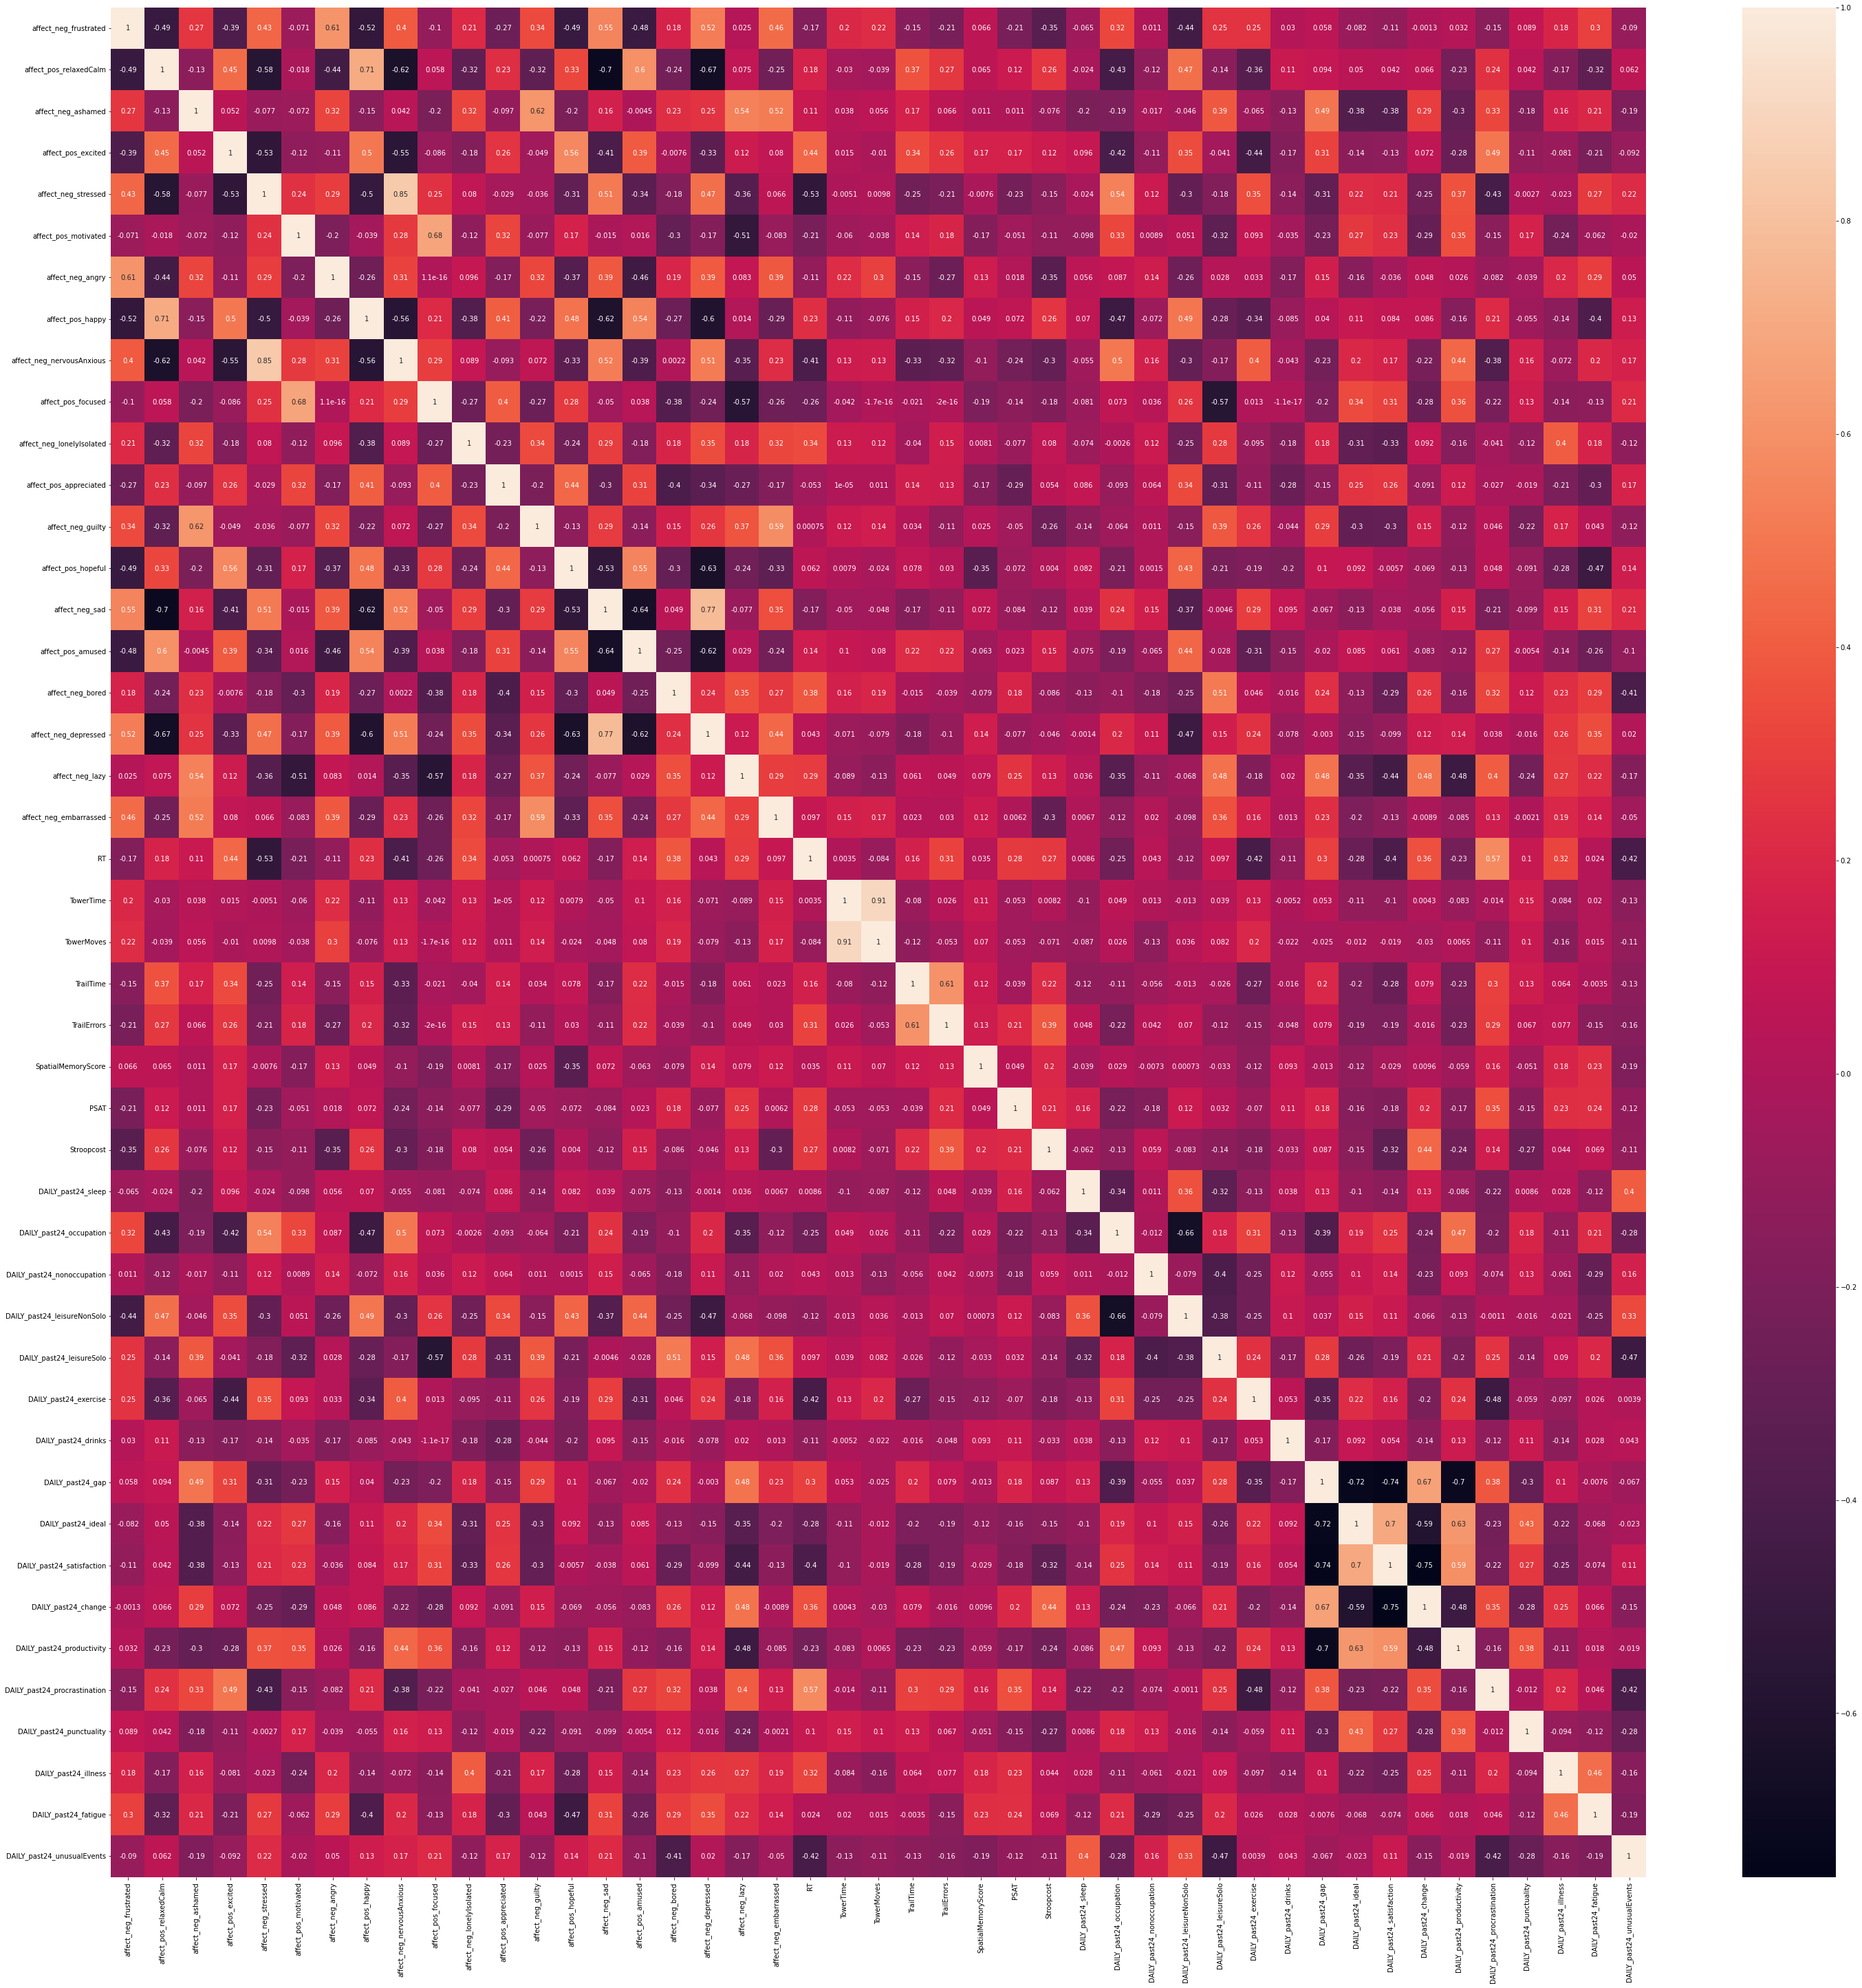

In [232]:
#creating the heapmap
df = pd.DataFrame(challenge,columns = list(challenge.keys()))
df = df.dropna(how='any',axis=0) 
corrMatrix = df.corr()
print(corrMatrix)
fig, ax = plt.subplots(figsize=(50,50))  
ax = sn.heatmap(corrMatrix, xticklabels=True, yticklabels=True,annot=True)